# LSB

* Using the LSB watermarking, embed the watermark in a bit that in neither the LSB nor the MSB. What happened? How this affect the results in terms of WPSNR?

* Embed the watermark and then attack your image before extracting the watermark. Can you still recover the watermark? if yes, when and how? Which attacks are the most effective? Which bit position guarantee more robustness? How does this affect the image quality?

* Geometric distortion are stron vs lsb


In [46]:
# wPSNR

import os
import numpy as np
import cv2
import matplotlib.pyplot as plt
from scipy.signal import convolve2d
from math import sqrt

def wpsnr(img1, img2):
  img1 = np.float32(img1)/255.0
  img2 = np.float32(img2)/255.0
  difference = img1-img2
  same = not np.any(difference)
  if same is True:
      return 9999999
  w = np.genfromtxt('csf.csv', delimiter=',')
  ew = convolve2d(difference, np.rot90(w,2), mode='valid')
  decibels = 20.0*np.log10(1.0/sqrt(np.mean(np.mean(ew**2))))
  return decibels

In [ ]:
#YOUR CODE

# Read image 
im = cv2.imread('lena_grey.bmp', 0)
# Check Image Shape
print('Image shape: ', np.shape(im))

#Genetate your watermark
N = 1024 #watermark size
watermark = (np.random.normal(0, 1, N) > 0).astype(int)
print('Watermark: ', watermark)

# Flatted the images for easy embedding
pixels = im.flatten()

# Example of decoded pixel value
pixel_format = format(pixels[0], "08b")
print(pixel_format)
print(type(pixel_format))

# Embedding
for i in range(N):
  im_pixel_bytes = format(pixels[i], "08b")

  # concate all the pixels until the LSB from the image
  # and the MSB of the watermark as LSB
  watermarked_data = im_pixel_bytes[1:7] + str(watermark[i])

  #encoding bytes back to pixels
  pixels[i] = int(watermarked_data, 2)

# Reshape image
watermarked_img = pixels.reshape(512, 512)

# Show images side by side
plt.figure(figsize=(15, 9))
plt.subplot(121)
plt.title('Original')
plt.imshow(im, cmap='gray')
plt.subplot(122)
plt.title('Watermarked')
plt.imshow(watermarked_img,cmap='gray')
plt.show()

# save image
cv2.imwrite('watermarked.bmp', watermarked_img)

wpsnr(watermarked_img, im)

In [48]:
#List of different attacks

import os
import numpy as np
import cv2
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc
from scipy.fft import dct, idct

import random

#this seed was set just to make you obtain the same result
random.seed(3)
def awgn(img, std, seed):
  mean = 0.0   # some constant
  #np.random.seed(seed)
  attacked = img + np.random.normal(mean, std, img.shape)
  attacked = np.clip(attacked, 0, 255)
  return attacked

def blur(img, sigma):
  from scipy.ndimage.filters import gaussian_filter
  attacked = gaussian_filter(img, sigma)
  return attacked

def sharpening(img, sigma, alpha):
  import scipy
  from scipy.ndimage import gaussian_filter
  import matplotlib.pyplot as plt

  #print(img/255)
  filter_blurred_f = gaussian_filter(img, sigma)

  attacked = img + alpha * (img - filter_blurred_f)
  return attacked

def median(img, kernel_size):
  from scipy.signal import medfilt
  attacked = medfilt(img, kernel_size)
  return attacked

def resizing(img, scale):
  from skimage.transform import rescale
  x, y = img.shape
  attacked = rescale(img, scale)
  attacked = rescale(attacked, 1/scale)
  attacked = attacked[:x, :y]
  return attacked

def jpeg_compression(img, QF):
  from PIL import Image
  img = Image.fromarray(img)
  img.save('tmp.jpg',"JPEG", quality=QF)
  attacked = Image.open('tmp.jpg')
  attacked = np.asarray(attacked,dtype=np.uint8)
  os.remove('tmp.jpg')

  return attacked


In [ ]:
# Attack the image

attacked = jpeg_compression(watermarked_img, 100)
cv2.imwrite('watermarked.bmp', attacked)

# Show images side by side
plt.figure(figsize=(15, 9))
plt.subplot(131)
plt.title('Original')
plt.imshow(im, cmap='gray')
plt.subplot(132)
plt.title('Watermarked')
plt.imshow(watermarked_img,cmap='gray')
plt.subplot(133)
plt.title('Attacked')
plt.imshow(attacked,cmap='gray')
plt.show()

print(wpsnr(im, im))
print(wpsnr(watermarked_img, im))
print(wpsnr(attacked, im))


In [ ]:
# Check for watermar

# Read the watermarked image and flatten it
watermarked = cv2.imread('watermarked.bmp', 0)
#move from a matrix to an array
watermarked = watermarked.flatten()
# Create empy flatten watermark array
extracted_watermarked = np.zeros(N)
for i in range(N):
  extracted_watermarked[i] = int(format(watermarked[i], "08b")[-1], 2) #[-1] locate the pixels LSB (i.e. the last position). If you embed the watermark in another position, change the value inside [] accordingly 

def similarity(X,X_star):
    #Computes the similarity measure between the original and the new watermarks.
    s = np.sum(np.multiply(X, X_star)) / np.sqrt(np.sum(np.multiply(X_star, X_star)))
    return s

def compute_thr(sim, mark_size, w, N):
    SIM = np.zeros(N)
    for i in range(N):
        r = np.random.uniform(0.0, 1.0, mark_size)
        SIM[i] = (similarity(w, r))
    SIMs = SIM.copy()
    SIM.sort()
    t = SIM[-1]
    T = t + (0.1*t)
    print('Threshold: ', T)
    return T, SIMs

sim = similarity(watermark, extracted_watermarked)
T, SIM_arr = compute_thr(sim, N, watermark, N)
plt.plot(SIM_arr, label='different watermarks')
plt.plot(np.ones(N)*T, label='threshold')
plt.plot(sim, 'x', label='same watermark')
plt.legend()
plt.ylabel('similarity')
plt.xlabel('test sample')


if sim > T:
    print('Mark has been found. SIM = %f' % sim)
else:
    print('Mark has been lost. SIM = %f' % sim)


## Spread Spectrum:

1. Change the value of alpha

2. Compute the PSNR and WPSNR of watermarked images for 3 different values of alpha in the multiplicative version of the SS

3. Can you still detect the watermark if the image is attacked? Use different attack of Lab 1 to see how these affect the detection.

4. Play with the complete SS code (embedding + detection) and see what happens if you select different coefficients (e.g. low to mid frequencies).

5. Substiture the DCT with a transformation of your choice (wavelet of FFT). Which one works better? Does it improve of worse the results obtained using the DCT?

In [ ]:
#YOUR CODE
# embedding function using DCT

import os
from scipy.fft import dct, idct
import numpy as np
import matplotlib.pyplot as plt
import cv2
from scipy.signal import convolve2d
from math import sqrt

im = cv2.imread('lena_grey.bmp', 0)
img_path='lena_grey.bmp'
N = 1024

#v = 'additive'
#alpha = 24 
v = 'multiplicative'
alphaUno = 0.1
alphaDue = 0.2
alphaTre = 0.3
np.random.seed(seed=123)

image = cv2.imread(img_path, 0)

def embedding(image, mark_size, alpha, v='multiplicative'):
    # Get the DCT transform of the image
    ori_dct = dct(dct(image,axis=0, norm='ortho'),axis=1, norm='ortho')

    # Get the locations of the most perceptually significant components
    sign = np.sign(ori_dct)
    ori_dct = abs(ori_dct)
    locations = np.argsort(-ori_dct,axis=None) # - sign is used to get descending order
    rows = image.shape[0]
    locations = [(val//rows, val%rows) for val in locations] # locations as (x,y) coordinates

    # Generate a watermark
    mark = np.random.uniform(0.0, 1.0, mark_size)
    mark = np.uint8(np.rint(mark))
    np.save('mark.npy', mark)

    # Embed the watermark
    watermarked_dct = ori_dct.copy()
    for idx, (loc,mark_val) in enumerate(zip(locations[1:], mark)):
        if v == 'additive':
            watermarked_dct[loc] += (alpha * mark_val)
        elif v == 'multiplicative':
            watermarked_dct[loc] *= 1 + ( alpha * mark_val)

    # Restore sign and o back to spatial domain
    watermarked_dct *= sign
    watermarked = np.uint8(idct(idct(watermarked_dct,axis=1, norm='ortho'),axis=0, norm='ortho'))

    return mark, watermarked


mark, watermarkedUno = embedding(image, N, alphaUno, v)
cv2.imwrite('watermarkedUno.bmp', watermarkedUno)
mark, watermarkedDue = embedding(image, N, alphaDue, v)
cv2.imwrite('watermarkedDue.bmp', watermarkedDue)
mark, watermarkedTre = embedding(image, N, alphaTre, v)
cv2.imwrite('watermarkedTre.bmp', watermarkedTre)

# Show images side by side
plt.figure(figsize=(15, 9))
plt.subplot(131)
plt.title('Alpha = 0.1')
plt.imshow(watermarkedUno, cmap='gray')
plt.subplot(132)
plt.title('Alpha = 0.2')
plt.imshow(watermarkedDue,cmap='gray')
plt.subplot(133)
plt.title('Alpha = 0.3')
plt.imshow(watermarkedTre,cmap='gray')
plt.show()


print(wpsnr(watermarkedUno,im))
print(wpsnr(watermarkedDue,im))
print(wpsnr(watermarkedTre,im))

In [ ]:
# embedding function using FFT

import os
from scipy.fft import dct, idct
import numpy as np
import matplotlib.pyplot as plt
import cv2
from scipy.signal import convolve2d
from math import sqrt

im = cv2.imread('lena_grey.bmp', 0)
img_path='lena_grey.bmp'
N = 1024

#v = 'additive'
#alpha = 24 
v = 'multiplicative'
alphaUno = 0.1
alphaDue = 0.2
alphaTre = 0.3
np.random.seed(seed=123)

image = cv2.imread(img_path, 0)


def embeddingfft(image, mark_size, alpha, v='multiplicative'):
    # Apply 2D FFT to the image
    ori_fft = np.fft.fft2(image)
    
    # Get the magnitude and phase of the FFT
    magnitude = np.abs(ori_fft)
    phase = np.angle(ori_fft)

    # Get the locations of the most perceptually significant components (highest magnitudes)
    locations = np.argsort(-magnitude, axis=None)  # - sign for descending order
    rows = image.shape[0]
    locations = [(val // rows, val % rows) for val in locations]  # Convert to (x, y) coordinates

    # Generate a random watermark
    mark = np.random.uniform(0.0, 1.0, mark_size)
    mark = np.uint8(np.rint(mark))  # Binary watermark
    np.save('mark.npy', mark)

    # Embed the watermark in the high-magnitude FFT components
    watermarked_magnitude = magnitude.copy()
    for idx, (loc, mark_val) in enumerate(zip(locations[1:], mark)):
        if v == 'additive':
            watermarked_magnitude[loc] += alpha * mark_val
        elif v == 'multiplicative':
            watermarked_magnitude[loc] *= 1 + alpha * mark_val

    # Combine the modified magnitude with the original phase
    watermarked_fft = watermarked_magnitude * np.exp(1j * phase)

    # Apply inverse FFT to get back the spatial domain image
    watermarked_image = np.fft.ifft2(watermarked_fft)
    watermarked_image = np.abs(watermarked_image)  # Take the absolute value since the result might be complex

    # Convert to uint8 for display or saving
    watermarked_image = np.uint8(np.clip(watermarked_image, 0, 255))

    return mark, watermarked_image

mark, watermarkedUno = embeddingfft(image, N, alphaUno, v)
cv2.imwrite('watermarkedUno.bmp', watermarkedUno)
mark, watermarkedDue = embeddingfft(image, N, alphaDue, v)
cv2.imwrite('watermarkedDue.bmp', watermarkedDue)
mark, watermarkedTre = embeddingfft(image, N, alphaTre, v)
cv2.imwrite('watermarkedTre.bmp', watermarkedTre)

# Show images side by side
plt.figure(figsize=(15, 9))
plt.subplot(131)
plt.title('Alpha = 0.1')
plt.imshow(watermarkedUno, cmap='gray')
plt.subplot(132)
plt.title('Alpha = 0.2')
plt.imshow(watermarkedDue,cmap='gray')
plt.subplot(133)
plt.title('Alpha = 0.3')
plt.imshow(watermarkedTre,cmap='gray')
plt.show()


print(wpsnr(watermarkedUno,im))
print(wpsnr(watermarkedDue,im))
print(wpsnr(watermarkedTre,im))

In [ ]:
# embedding function using DWT twice (on the LL)

import numpy as np
import cv2
import pywt
import matplotlib.pyplot as plt

import os
from scipy.fft import dct, idct
import numpy as np
import matplotlib.pyplot as plt
import cv2
from scipy.signal import convolve2d
from math import sqrt

im = cv2.imread('lena_grey.bmp', 0)
img_path='lena_grey.bmp'
N = 1024

#v = 'additive'
#alpha = 24 
v = 'multiplicative'
alphaUno = 0.1
alphaDue = 0.2
alphaTre = 0.47
np.random.seed(seed=123)

image = cv2.imread(img_path, 0)


def embeddingwt(image, mark_size, alpha, v='multiplicative'):

    # Generate a watermark
    mark = np.random.uniform(0.0, 1.0, mark_size)
    mark = np.uint8(np.rint(mark))
    np.save('mark.npy', mark)

    coeffs2 = pywt.dwt2(image, 'haar')
    LL, (LH, HL, HH) = coeffs2

    coeffs3 = pywt.dwt2(LL, 'haar')
    LL2, (LH2, HL2, HH2) = coeffs3

    # Get the locations in LH
    sign_LH2 = np.sign(LH2)
    abs_LH2 = abs(LH2)
    locations_LH2 = np.argsort(-abs_LH2,axis=None) # - sign is used to get descending order
    rows_LH2 = LH2.shape[0]
    locations_LH2 = [(val//rows_LH2, val%rows_LH2) for val in locations_LH2] # locations as (x,y) coordinates

    # Get the locations in HL
    sign_HL2 = np.sign(HL2)
    abs_HL2 = abs(HL2)
    locations_HL2 = np.argsort(-abs_HL2,axis=None) # - sign is used to get descending order
    rows_HL2 = HL2.shape[0]
    locations_HL2 = [(val//rows_HL2, val%rows_HL2) for val in locations_HL2] # locations as (x,y) coordinates

    # Get the locations in HH
    sign_HH2 = np.sign(HH2)
    abs_HH2 = abs(HH2)
    locations_HH2 = np.argsort(-abs_HH2,axis=None) # - sign is used to get descending order
    rows_HH2 = HH2.shape[0]
    locations_HH2 = [(val//rows_HH2, val%rows_HH2) for val in locations_HH2] # locations as (x,y) coordinates
    # Embed the watermark in LH
    watermarked_LH2 = abs_LH2.copy()
    for idx, (loc,mark_val) in enumerate(zip(locations_LH2[1:], mark)):
        if v == 'additive':
            watermarked_LH2[loc] += (alpha * mark_val)
        elif v == 'multiplicative':
            watermarked_LH2[loc] *= 1 + ( alpha * mark_val)
    
     # Embed the watermark in LH
    watermarked_HL2 = abs_HL2.copy()
    for idx, (loc,mark_val) in enumerate(zip(locations_HL2[1:], mark)):
        if v == 'additive':
            watermarked_HL2[loc] += (alpha * mark_val)
        elif v == 'multiplicative':
            watermarked_HL2[loc] *= 1 + ( alpha * mark_val)
    
     # Embed the watermark in HH
    watermarked_HH2 = abs_HH2.copy()
    for idx, (loc,mark_val) in enumerate(zip(locations_HH2[1:], mark)):
        if v == 'additive':
            watermarked_HH2[loc] += (alpha * mark_val)
        elif v == 'multiplicative':
            watermarked_HH2[loc] *= 1 + ( alpha * mark_val)

    # Restore sign and o back to spatial domain
    watermarked_LH2 *= sign_LH2
    watermarked_HL2 *= sign_HL2
    watermarked_HH2 *= sign_HH2
    watermarked_LL = pywt.idwt2((LL2, (watermarked_LH2, watermarked_HL2, watermarked_HH2)), 'haar')
    watermarked = pywt.idwt2((watermarked_LL, (LH, HL, HH)), 'haar')

    return mark, watermarked


mark, watermarkedUno = embeddingwt(image, N, alphaUno, v)
cv2.imwrite('watermarkedUno.bmp', watermarkedUno)
mark, watermarkedDue = embeddingwt(image, N, alphaDue, v)
cv2.imwrite('watermarkedDue.bmp', watermarkedDue)
mark, watermarkedTre = embeddingwt(image, N, alphaTre, v)
cv2.imwrite('watermarkedTre.bmp', watermarkedTre)


# Show images side by side
plt.figure(figsize=(15, 9))
plt.subplot(141)
plt.title('Alpha = 0.1')
plt.imshow(watermarkedUno, cmap='gray')
plt.subplot(142)
plt.title('Alpha = 0.2')
plt.imshow(watermarkedDue,cmap='gray')
plt.subplot(143)
plt.title('Alpha = 0.3')
plt.imshow(watermarkedTre,cmap='gray')
plt.figure(figsize=(15, 9))
plt.show()


print(wpsnr(watermarkedUno,im))
print(wpsnr(watermarkedDue,im))
print(wpsnr(watermarkedTre,im))


In [ ]:
# Attack the image
# The base line is 34.3789397907575 using DCT
#attacked = awgn(watermarkedTre, 46, 3) #29.55657853312519
#attacked = blur(watermarkedTre, 2) #32.51845857049855
#attacked = sharpening(watermarkedTre, 1, 3) #28.606725811065182
#attacked = sharpening(watermarkedTre, 2, 1) #29.36471405293567
#attacked = median(watermarkedTre, [9,9]) #31.71783305231363
#attacked = resizing(watermarkedTre, 50) #not shure about this
#attacked = jpeg_compression(watermarkedTre, 4) #31.256930388906486


# The base line is 36.036668547800005 using FFT
#attacked = awgn(watermarkedTre, 42, 3) #30.456733569429044
#attacked = blur(watermarkedTre, 2) #33.44298944133008
#attacked = sharpening(watermarkedTre, 1, 3) #29.372178909856235
#attacked = sharpening(watermarkedTre, 2, 1) #30.67017636801896
#attacked = median(watermarkedTre, [9,9]) #31.71783305231363
#attacked = resizing(watermarkedTre, 50) #not shure about this
#attacked = jpeg_compression(watermarkedTre, 4) #31.256930388906486


# The base line is 50.009449145807885 using DWT
attacked = awgn(watermarkedTre, 24, 123) #35.56329846228041
#attacked = blur(watermarkedTre, 2) #32.51845857049855
#attacked = sharpening(watermarkedTre, 1, 3) #28.606725811065182
#attacked = sharpening(watermarkedTre, 2, 1) #29.36471405293567
#attacked = median(watermarkedTre, [9,9]) #31.71783305231363
#attacked = resizing(watermarkedTre, 50) #not shure about this
#attacked = jpeg_compression(watermarkedTre, 4) #31.256930388906486

#attacked = jpeg_compression(watermarkedTre, 90) #31.256930388906486
#attacked = watermarkedTre

#cv2.imwrite('watermarked.bmp', attacked)

# Show images side by side
plt.figure(figsize=(15, 9))
plt.subplot(131)
plt.title('Original')
plt.imshow(im, cmap='gray')
plt.subplot(132)
plt.title('Watermarked')
plt.imshow(watermarkedTre,cmap='gray')
plt.subplot(133)
plt.title('Attacked')
plt.imshow(attacked,cmap='gray')
plt.show()

print(wpsnr(im, im))
print(wpsnr(watermarkedTre, im))
print(wpsnr(attacked, im))

In [ ]:
# Check for watermark DCT

def detection(image, watermarked, alpha, mark_size, v='multiplicative'):
    ori_dct = dct(dct(image,axis=0, norm='ortho'),axis=1, norm='ortho')
    wat_dct = dct(dct(watermarked,axis=0, norm='ortho'),axis=1, norm='ortho')

    # Get the locations of the most perceptually significant components
    ori_dct = abs(ori_dct)
    wat_dct = abs(wat_dct)
    locations = np.argsort(-ori_dct,axis=None) # - sign is used to get descending order
    rows = image.shape[0]
    locations = [(val//rows, val%rows) for val in locations] # locations as (x,y) coordinates

    # Generate a watermark
    w_ex = np.zeros(mark_size, dtype=np.float64)

    # Embed the watermark
    for idx, loc in enumerate(locations[1:mark_size+1]):
        if v=='additive':
            w_ex[idx] =  (wat_dct[loc] - ori_dct[loc]) /alpha
        elif v=='multiplicative':
            w_ex[idx] =  (wat_dct[loc] - ori_dct[loc]) / (alpha*ori_dct[loc])
            
    return w_ex

w_ex = detection(image, attacked, alphaTre, N, v)


def similarity(X,X_star):
    #Computes the similarity measure between the original and the new watermarks.
    s = np.sum(np.multiply(X, X_star)) / np.sqrt(np.sum(np.multiply(X_star, X_star)))
    return s

def compute_thr(sim, mark_size, w):
    SIM = np.zeros(1000)
    for i in range(1, 1000):
        r = np.random.uniform(0.0, 1.0, mark_size)
        SIM[i] = (similarity(w, r))
    
    SIM.sort()
    t = SIM[-1]
    T = t + (0.1*t)
    print('threshold: ', T)
    return T

sim = similarity(mark, w_ex)
T = compute_thr(sim, N, mark)

if sim > T:
    print('Mark has been found. SIM = %f' % sim)
else:
    print('Mark has been lost. SIM = %f' % sim)

In [ ]:
# Check for watermark FFT

from numpy.fft import fft2, ifft2

def detection(image, watermarked, alpha, mark_size, v='multiplicative'):
    # Perform 2D FFT on both original and watermarked images
    ori_fft = fft2(image)
    wat_fft = fft2(watermarked)

    # Get the magnitude of the FFT coefficients (analogous to the DCT's abs values)
    ori_fft = abs(ori_fft)
    wat_fft = abs(wat_fft)

    # Get the locations of the most perceptually significant components (largest magnitude FFT coefficients)
    locations = np.argsort(-ori_fft, axis=None)  # - sign is used to get descending order
    rows = image.shape[0]
    locations = [(val // rows, val % rows) for val in locations]  # locations as (x,y) coordinates

    # Initialize an empty array for the extracted watermark
    w_ex = np.zeros(mark_size, dtype=np.float64)

    # Extract the watermark using the chosen method (additive or multiplicative)
    for idx, loc in enumerate(locations[1:mark_size+1]):
        if v == 'additive':
            w_ex[idx] = (wat_fft[loc] - ori_fft[loc]) / alpha
        elif v == 'multiplicative':
            w_ex[idx] = (wat_fft[loc] - ori_fft[loc]) / (alpha * ori_fft[loc])

    return w_ex

w_ex = detection(image, attacked, alphaTre, N, v)

def similarity(X,X_star):
    #Computes the similarity measure between the original and the new watermarks.
    s = np.sum(np.multiply(X, X_star)) / np.sqrt(np.sum(np.multiply(X_star, X_star)))
    return s

def compute_thr(sim, mark_size, w):
    SIM = np.zeros(1000)
    for i in range(1, 1000):
        r = np.random.uniform(0.0, 1.0, mark_size)
        SIM[i] = (similarity(w, r))
    
    SIM.sort()
    t = SIM[-1]
    T = t + (0.1*t)
    print('threshold: ', T)
    return T

sim = similarity(mark, w_ex)
T = compute_thr(sim, N, mark)

if sim > T:
    print('Mark has been found. SIM = %f' % sim)
else:
    print('Mark has been lost. SIM = %f' % sim)


In [ ]:
#5
import pywt
import os
from scipy.fft import dct, idct
import numpy as np
import matplotlib.pyplot as plt
import cv2
from scipy.signal import convolve2d
from math import sqrt

def similarity(X,X_star):
    #Computes the similarity measure between the original and the new watermarks.
    s = np.sum(np.multiply(X, X_star)) / (np.sqrt(np.sum(np.multiply(X, X))) * np.sqrt(np.sum(np.multiply(X_star, X_star))))
    return s


def compute_thr(sim, mark_size, w, N):
    SIM = np.zeros(N)
    for i in range(N):
        r = np.random.uniform(0.0, 1.0, mark_size)
        SIM[i] = (similarity(w, r))
    SIMs = SIM.copy()
    SIM.sort()
    t = SIM[-1]
    T = t + (0.1*t)
    print('Threshold: ', T)
    return T, SIMs
#select your attack 

def awgn(img, std, seed):
  mean = 0.0   # some constant
  np.random.seed(seed)
  attacked = img + np.random.normal(mean, std, img.shape)
  attacked = np.clip(attacked, 0, 255)
  return np.uint8(attacked)

def wpsnr(img1, img2):
  img1 = np.float32(img1)/255.0
  img2 = np.float32(img2)/255.0
  difference = img1-img2
  same = not np.any(difference)
  if same is True:
      return 9999999
  w = np.genfromtxt('csf.csv', delimiter=',')
  ew = convolve2d(difference, np.rot90(w,2), mode='valid')
  decibels = 20.0*np.log10(1.0/sqrt(np.mean(np.mean(ew**2))))
  return decibels

def embedding(image, mark_size, alpha, v='multiplicative'):

    # Generate a watermark
    mark = np.random.uniform(0.0, 1.0, mark_size)
    mark = np.uint8(np.rint(mark))
    np.save('mark.npy', mark)

    coeffs2 = pywt.dwt2(image, 'haar')
    LL, (LH, HL, HH) = coeffs2

    # Get the locations in LH
    sign_LH = np.sign(LH)
    abs_LH = abs(LH)
    locations_LH = np.argsort(-abs_LH,axis=None) # - sign is used to get descending order
    rows_LH = LH.shape[0]
    locations_LH = [(val//rows_LH, val%rows_LH) for val in locations_LH] # locations as (x,y) coordinates

    # Get the locations in HL
    sign_HL = np.sign(HL)
    abs_HL = abs(HL)
    locations_HL = np.argsort(-abs_HL,axis=None) # - sign is used to get descending order
    rows_HL = HL.shape[0]
    locations_HL = [(val//rows_HL, val%rows_HL) for val in locations_HL] # locations as (x,y) coordinates

    # Get the locations in HH
    sign_HH = np.sign(HH)
    abs_HH = abs(HH)
    locations_HH = np.argsort(-abs_HH,axis=None) # - sign is used to get descending order
    rows_HH = HH.shape[0]
    locations_HH = [(val//rows_HH, val%rows_HH) for val in locations_HH] # locations as (x,y) coordinates
    
    # Embed the watermark in LH
    watermarked_LH = abs_LH.copy()
    for idx, (loc,mark_val) in enumerate(zip(locations_LH[1:], mark)):
        if v == 'additive':
            watermarked_LH[loc] += (alpha * mark_val)
        elif v == 'multiplicative':
            watermarked_LH[loc] *= 1 + ( alpha * mark_val)
    
     # Embed the watermark in LH
    watermarked_HL = abs_HL.copy()
    for idx, (loc,mark_val) in enumerate(zip(locations_HL[1:], mark)):
        if v == 'additive':
            watermarked_HL[loc] += (alpha * mark_val)
        elif v == 'multiplicative':
            watermarked_HL[loc] *= 1 + ( alpha * mark_val)
    
     # Embed the watermark in HH
    watermarked_HH = abs_HH.copy()
    for idx, (loc,mark_val) in enumerate(zip(locations_HH[1:], mark)):
        if v == 'additive':
            watermarked_HH[loc] += (alpha * mark_val)
        elif v == 'multiplicative':
            watermarked_HH[loc] *= 1 + ( alpha * mark_val)

    # Restore sign and o back to spatial domain
    watermarked_LH *= sign_LH
    watermarked_HL *= sign_HL
    watermarked_HH *= sign_HH
    watermarked = pywt.idwt2((LL, (watermarked_LH, watermarked_HL, watermarked_HH)), 'haar')

    return mark, watermarked

def detection(image, watermarked, alpha, mark_size, v='multiplicative'):
    #ori_dct = dct(dct(image,axis=0, norm='ortho'),axis=1, norm='ortho')
    coeffs2 = pywt.dwt2(image, 'haar')
    LL_or, (LH_or, HL_or, HH_or) = coeffs2
    #wat_dct = dct(dct(watermarked,axis=0, norm='ortho'),axis=1, norm='ortho')
    coeffs2 = pywt.dwt2(watermarked, 'haar')
    LL_w, (LH_w, HL_w, HH_w) = coeffs2

    #
    # Get the locations in LH
    sign_LH = np.sign(LH_or)
    abs_LH = abs(LH_or)
    locations_LH = np.argsort(-abs_LH,axis=None) # - sign is used to get descending order
    rows_LH = LH_or.shape[0]
    locations_LH = [(val//rows_LH, val%rows_LH) for val in locations_LH] # locations as (x,y) coordinates

    # Get the locations in HL
    sign_HL = np.sign(HL_or)
    abs_HL = abs(HL_or)
    locations_HL = np.argsort(-abs_HL,axis=None) # - sign is used to get descending order
    rows_HL = HL_or.shape[0]
    locations_HL = [(val//rows_HL, val%rows_HL) for val in locations_HL] # locations as (x,y) coordinates

    # Get the locations in HH
    sign_HH = np.sign(HH_or)
    abs_HH = abs(HH_or)
    locations_HH = np.argsort(-abs_HH,axis=None) # - sign is used to get descending order
    rows_HH = HH_or.shape[0]
    locations_HH = [(val//rows_HH, val%rows_HH) for val in locations_HH] # locations as (x,y) coordinates

    # Generate a watermark
    w_ex1 = np.zeros(mark_size, dtype=np.float64)
    w_ex2 = np.zeros(mark_size, dtype=np.float64)
    w_ex3 = np.zeros(mark_size, dtype=np.float64)

    # Embed the watermark
    for idx, loc in enumerate(locations_LH[1:mark_size+1]):
        if v=='additive':
            w_ex1[idx] =  (LH_w[loc] - LH_or[loc]) /alpha
        elif v=='multiplicative':
            w_ex1[idx] =  (LH_w[loc] - LH_or[loc]) / (alpha*LH_or[loc])
    
     # Embed the watermark
    for idx, loc in enumerate(locations_HL[1:mark_size+1]):
        if v=='additive':
            w_ex2[idx] =  (HL_w[loc] - HL_or[loc]) /alpha
        elif v=='multiplicative':
            w_ex2[idx] =  (HL_w[loc] - HL_or[loc]) / (alpha*HL_or[loc])

     # Embed the watermark
    for idx, loc in enumerate(locations_HH[1:mark_size+1]):
        if v=='additive':
            w_ex3[idx] =  (HH_w[loc] - HH_or[loc]) /alpha
        elif v=='multiplicative':
            w_ex3[idx] =  (HH_w[loc] - HH_or[loc]) / (alpha*HH_or[loc])
    
    w_ex = (w_ex1 + w_ex2 + w_ex3)/3
    return w_ex


plt.figure(figsize=(20, 20))

img_path='lena_grey.bmp'
N = 1024

#v = 'additive'
#alpha = 24 
v = 'multiplicative'
alpha = 0.9
np.random.seed(seed=123)

image = cv2.imread(img_path, 0)

mark, watermarked1 = embedding(image, N, alpha, v)


#######  your attack  ########

attacked = awgn(watermarked1, 24, 123)


plt.subplot(131)
plt.title('Original')
plt.imshow(image, cmap='gray')
plt.subplot(132)
plt.title('Watermarked')
plt.imshow(watermarked1, cmap='gray')
plt.subplot(133)
plt.title('Attacked Watermarked')
plt.imshow(attacked,cmap='gray')
#detection

w_ex = detection(image, watermarked1, alpha, N, v)
w_ex_att = detection(image, attacked, alpha, N, v)

#wpsnr
wspnr_watermarked = wpsnr(image, watermarked1)
wpsner_attacked = wpsnr(image, attacked)
print('\n')
print('WPSNR non-ATTACKED IMAGE = ', wspnr_watermarked)
print('WPSNR ATTACKED IMAGE = ', wpsner_attacked)
#similarity
sim_Attacked = similarity(w_ex,w_ex_att)
sim_NOTattacked = similarity(mark,w_ex)
Tau, _ = compute_thr(sim_NOTattacked, N, mark, 1000)
#watermark retrieved?
print('\n')
if sim_NOTattacked > Tau:
        print('Mark has been found in the non-attacked image. SIM = %f' % sim_NOTattacked)
else:
        print('Mark has been lost in the non-attacked image. SIM = %f' % sim_NOTattacked)
if sim_Attacked > Tau:
        print('Mark has been found in the attacked image. SIM = %f' % sim_Attacked)
else:
        print('Mark has been lost in the attacked image. SIM = %f' % sim_Attacked)
print('--------------------------')
print('\n')


In [ ]:
#5
import pywt
import os
from scipy.fft import dct, idct
import numpy as np
import matplotlib.pyplot as plt
import cv2
from scipy.signal import convolve2d
from math import sqrt

def similarity(X,X_star):
    #Computes the similarity measure between the original and the new watermarks.
    s = np.sum(np.multiply(X, X_star)) / (np.sqrt(np.sum(np.multiply(X, X))) * np.sqrt(np.sum(np.multiply(X_star, X_star))))
    return s


def compute_thr(sim, mark_size, w, N):
    SIM = np.zeros(N)
    for i in range(N):
        r = np.random.uniform(0.0, 1.0, mark_size)
        SIM[i] = (similarity(w, r))
    SIMs = SIM.copy()
    SIM.sort()
    t = SIM[-1]
    T = t + (0.1*t)
    print('Threshold: ', T)
    return T, SIMs
#select your attack 

def awgn(img, std, seed):
  mean = 0.0   # some constant
  np.random.seed(seed)
  attacked = img + np.random.normal(mean, std, img.shape)
  attacked = np.clip(attacked, 0, 255)
  return np.uint8(attacked)

def wpsnr(img1, img2):
  img1 = np.float32(img1)/255.0
  img2 = np.float32(img2)/255.0
  difference = img1-img2
  same = not np.any(difference)
  if same is True:
      return 9999999
  w = np.genfromtxt('csf.csv', delimiter=',')
  ew = convolve2d(difference, np.rot90(w,2), mode='valid')
  decibels = 20.0*np.log10(1.0/sqrt(np.mean(np.mean(ew**2))))
  return decibels

def embedding(image, mark_size, alpha, v='multiplicative'):

    # Generate a watermark
    mark = np.random.uniform(0.0, 1.0, mark_size)
    mark = np.uint8(np.rint(mark))
    np.save('mark.npy', mark)

    coeffs2 = pywt.dwt2(image, 'haar')
    LL, (LH, HL, HH) = coeffs2
    coeffs3 = pywt.dwt2(LL, 'haar')
    LL2, (LH2, HL2, HH2) = coeffs3

    # Get the locations in LH2
    sign_LH2 = np.sign(LH2)
    abs_LH2 = abs(LH2)
    locations_LH2 = np.argsort(-abs_LH2,axis=None) # - sign is used to get descending order
    rows_LH2 = LH2.shape[0]
    locations_LH2 = [(val//rows_LH2, val%rows_LH2) for val in locations_LH2] # locations as (x,y) coordinates

    # Get the locations in HL2
    sign_HL2 = np.sign(HL2)
    abs_HL2 = abs(HL2)
    locations_HL2 = np.argsort(-abs_HL2,axis=None) # - sign is used to get descending order
    rows_HL2 = HL2.shape[0]
    locations_HL2 = [(val//rows_HL2, val%rows_HL2) for val in locations_HL2] # locations as (x,y) coordinates

    # Get the locations in HH2
    sign_HH2 = np.sign(HH2)
    abs_HH2 = abs(HH2)
    locations_HH2 = np.argsort(-abs_HH2,axis=None) # - sign is used to get descending order
    rows_HH2 = HH2.shape[0]
    locations_HH2 = [(val//rows_HH2, val%rows_HH2) for val in locations_HH2] # locations as (x,y) coordinates
    # Embed the watermark in LH2
    watermarked_LH2 = abs_LH2.copy()
    for idx, (loc,mark_val) in enumerate(zip(locations_LH2[1:], mark)):
        if v == 'additive':
            watermarked_LH2[loc] += (alpha * mark_val)
        elif v == 'multiplicative':
            watermarked_LH2[loc] *= 1 + (alpha * mark_val)
    
     # Embed the watermark in LH
    watermarked_HL2 = abs_HL2.copy()
    for idx, (loc,mark_val) in enumerate(zip(locations_HL2[1:], mark)):
        if v == 'additive':
            watermarked_HL2[loc] += (alpha * mark_val)
        elif v == 'multiplicative':
            watermarked_HL2[loc] *= 1 + (alpha * mark_val)
    
     # Embed the watermark in HH
    watermarked_HH2 = abs_HH2.copy()
    for idx, (loc,mark_val) in enumerate(zip(locations_HH2[1:], mark)):
        if v == 'additive':
            watermarked_HH2[loc] += (alpha * mark_val)
        elif v == 'multiplicative':
            watermarked_HH2[loc] *= 1 + (alpha * mark_val)

    # Restore sign and o back to spatial domain
    watermarked_LH2 *= sign_LH2
    watermarked_HL2 *= sign_HL2
    watermarked_HH2 *= sign_HH2
    watermarked_LL = pywt.idwt2((LL2, (watermarked_LH2, watermarked_HL2, watermarked_HH2)), 'haar')
    watermarked = pywt.idwt2((watermarked_LL, (LH, HL, HH)), 'haar')

    return mark, watermarked

def detection(image, watermarked, alpha, mark_size, v='multiplicative'):
    #ori_dct = dct(dct(image,axis=0, norm='ortho'),axis=1, norm='ortho')
    coeffs2 = pywt.dwt2(image, 'haar')
    LL_or, (LH_or, HL_or, HH_or) = coeffs2
    coeffs3 = pywt.dwt2(LL_or, 'haar')
    LL2_or, (LH2_or, HL2_or, HH2_or) = coeffs3

    #wat_dct = dct(dct(watermarked,axis=0, norm='ortho'),axis=1, norm='ortho')
    coeffs4 = pywt.dwt2(watermarked, 'haar')
    LL_w, (LH_w, HL_w, HH_w) = coeffs4
    coeffs5 = pywt.dwt2(LL_w, 'haar')
    LL2_w, (LH2_w, HL2_w, HH2_w) = coeffs5

    #
    # Get the locations in LH2
    sign_LH2 = np.sign(LH2_or)
    abs_LH2 = abs(LH2_or)
    locations_LH2 = np.argsort(-abs_LH2,axis=None) # - sign is used to get descending order
    rows_LH2 = LH2_or.shape[0]
    locations_LH2 = [(val//rows_LH2, val%rows_LH2) for val in locations_LH2] # locations as (x,y) coordinates

    # Get the locations in HL2
    sign_HL2 = np.sign(HL2_or)
    abs_HL2 = abs(HL2_or)
    locations_HL2 = np.argsort(-abs_HL2,axis=None) # - sign is used to get descending order
    rows_HL2 = HL2_or.shape[0]
    locations_HL2 = [(val//rows_HL2, val%rows_HL2) for val in locations_HL2] # locations as (x,y) coordinates

    # Get the locations in HH2
    sign_HH2 = np.sign(HH2_or)
    abs_HH2 = abs(HH2_or)
    locations_HH2 = np.argsort(-abs_HH2,axis=None) # - sign is used to get descending order
    rows_HH2 = HH2_or.shape[0]
    locations_HH2 = [(val//rows_HH2, val%rows_HH2) for val in locations_HH2] # locations as (x,y) coordinates

    # Generate a watermark
    w_ex1 = np.zeros(mark_size, dtype=np.float64)
    w_ex2 = np.zeros(mark_size, dtype=np.float64)
    w_ex3 = np.zeros(mark_size, dtype=np.float64)

    # Embed the watermark
    for idx, loc in enumerate(locations_LH2[1:mark_size+1]):
        if v=='additive':
            w_ex1[idx] =  (LH2_w[loc] - LH2_or[loc]) /alpha
        elif v=='multiplicative':
            w_ex1[idx] =  (LH2_w[loc] - LH2_or[loc]) / (alpha*LH2_or[loc])
    
     # Embed the watermark
    for idx, loc in enumerate(locations_HL2[1:mark_size+1]):
        if v=='additive':
            w_ex2[idx] =  (HL2_w[loc] - HL2_or[loc]) /alpha
        elif v=='multiplicative':
            w_ex2[idx] =  (HL2_w[loc] - HL2_or[loc]) / (alpha*HL2_or[loc])

     # Embed the watermark
    for idx, loc in enumerate(locations_HH2[1:mark_size+1]):
        if v=='additive':
            w_ex3[idx] =  (HH2_w[loc] - HH2_or[loc]) /alpha
        elif v=='multiplicative':
            w_ex3[idx] =  (HH2_w[loc] - HH2_or[loc]) / (alpha*HH2_or[loc])
    
    w_ex = (w_ex1 + w_ex2 + w_ex3)/3
    return w_ex


plt.figure(figsize=(20, 20))

img_path='lena_grey.bmp'
N = 1024

#v = 'additive'
#alpha = 24 
v = 'multiplicative'
alpha = 0.18
np.random.seed(seed=123)

image = cv2.imread(img_path, 0)

mark, watermarked1 = embedding(image, N, alpha, v)
#your attack
attacked = awgn(watermarked1, 20, 123)
plt.subplot(131)
plt.title('Original')
plt.imshow(image, cmap='gray')
plt.subplot(132)
plt.title('Watermarked')
plt.imshow(watermarked1, cmap='gray')
plt.subplot(133)
plt.title('Attacked Watermarked')
plt.imshow(attacked,cmap='gray')
#detection

w_ex = detection(image, watermarked1, alpha, N, v)
w_ex_att = detection(image, attacked, alpha, N, v)

#wpsnr
wspnr_watermarked = wpsnr(image, watermarked1)
wpsner_attacked = wpsnr(image, attacked)
print('\n')
print('WPSNR non-ATTACKED IMAGE = ', wspnr_watermarked)
print('WPSNR ATTACKED IMAGE = ', wpsner_attacked)
#similarity
sim_Attacked = similarity(w_ex,w_ex_att)
sim_NOTattacked = similarity(mark,w_ex)
Tau, _ = compute_thr(sim_NOTattacked, N, mark, 1000)
#watermark retrieved?
print('\n')
if sim_NOTattacked > Tau:
        print('Mark has been found in the non-attacked image. SIM = %f' % sim_NOTattacked)
else:
        print('Mark has been lost in the non-attacked image. SIM = %f' % sim_NOTattacked)
if sim_Attacked > Tau:
        print('Mark has been found in the attacked image. SIM = %f' % sim_Attacked)
else:
        print('Mark has been lost in the attacked image. SIM = %f' % sim_Attacked)
print('--------------------------')
print('\n')


In [ ]:
#5
import pywt
import os
from scipy.fft import dct, idct
import numpy as np
import matplotlib.pyplot as plt
import cv2
from scipy.signal import convolve2d
from math import sqrt

def similarity(X,X_star):
    #Computes the similarity measure between the original and the new watermarks.
    s = np.sum(np.multiply(X, X_star)) / (np.sqrt(np.sum(np.multiply(X, X))) * np.sqrt(np.sum(np.multiply(X_star, X_star))))
    return s


def compute_thr(sim, mark_size, w, N):
    SIM = np.zeros(N)
    for i in range(N):
        r = np.random.uniform(0.0, 1.0, mark_size)
        SIM[i] = (similarity(w, r))
    SIMs = SIM.copy()
    SIM.sort()
    t = SIM[-1]
    T = t + (0.1*t)
    print('Threshold: ', T)
    return T, SIMs
#select your attack 

def awgn(img, std, seed):
  mean = 0.0   # some constant
  np.random.seed(seed)
  attacked = img + np.random.normal(mean, std, img.shape)
  attacked = np.clip(attacked, 0, 255)
  return np.uint8(attacked)

def wpsnr(img1, img2):
  img1 = np.float32(img1)/255.0
  img2 = np.float32(img2)/255.0
  difference = img1-img2
  same = not np.any(difference)
  if same is True:
      return 9999999
  w = np.genfromtxt('csf.csv', delimiter=',')
  ew = convolve2d(difference, np.rot90(w,2), mode='valid')
  decibels = 20.0*np.log10(1.0/sqrt(np.mean(np.mean(ew**2))))
  return decibels

def embedding(image, mark_size, alphaOne, alphaTwo, v='multiplicative'):

    # Generate a watermark
    mark = np.random.uniform(0.0, 1.0, mark_size)
    mark = np.uint8(np.rint(mark))
    np.save('mark.npy', mark)

    coeffs2 = pywt.dwt2(image, 'haar')
    LL, (LH, HL, HH) = coeffs2
    coeffs3 = pywt.dwt2(LL, 'haar')
    LL2, (LH2, HL2, HH2) = coeffs3

    # Get the locations in LH2
    sign_LH2 = np.sign(LH2)
    abs_LH2 = abs(LH2)
    locations_LH2 = np.argsort(-abs_LH2,axis=None) # - sign is used to get descending order
    rows_LH2 = LH2.shape[0]
    locations_LH2 = [(val//rows_LH2, val%rows_LH2) for val in locations_LH2] # locations as (x,y) coordinates

    # Get the locations in HL2
    sign_HL2 = np.sign(HL2)
    abs_HL2 = abs(HL2)
    locations_HL2 = np.argsort(-abs_HL2,axis=None) # - sign is used to get descending order
    rows_HL2 = HL2.shape[0]
    locations_HL2 = [(val//rows_HL2, val%rows_HL2) for val in locations_HL2] # locations as (x,y) coordinates

    # Get the locations in HH2
    sign_HH2 = np.sign(HH2)
    abs_HH2 = abs(HH2)
    locations_HH2 = np.argsort(-abs_HH2,axis=None) # - sign is used to get descending order
    rows_HH2 = HH2.shape[0]
    locations_HH2 = [(val//rows_HH2, val%rows_HH2) for val in locations_HH2] # locations as (x,y) coordinates
    
    # Embed the watermark in LH2
    watermarked_LH2 = abs_LH2.copy()
    for idx, (loc,mark_val) in enumerate(zip(locations_LH2[1:], mark)):
        if v == 'additive':
            watermarked_LH2[loc] += (alphaOne * mark_val)
        elif v == 'multiplicative':
            watermarked_LH2[loc] *= 1 + (alphaOne * mark_val)
    
     # Embed the watermark in LH2
    watermarked_HL2 = abs_HL2.copy()
    for idx, (loc,mark_val) in enumerate(zip(locations_HL2[1:], mark)):
        if v == 'additive':
            watermarked_HL2[loc] += (alphaOne * mark_val)
        elif v == 'multiplicative':
            watermarked_HL2[loc] *= 1 + (alphaOne * mark_val)
    
     # Embed the watermark in HH2
    watermarked_HH2 = abs_HH2.copy()
    for idx, (loc,mark_val) in enumerate(zip(locations_HH2[1:], mark)):
        if v == 'additive':
            watermarked_HH2[loc] += (alphaOne * mark_val)
        elif v == 'multiplicative':
            watermarked_HH2[loc] *= 1 + (alphaOne * mark_val)

    # Restore sign and o back to spatial domain
    watermarked_LH2 *= sign_LH2
    watermarked_HL2 *= sign_HL2
    watermarked_HH2 *= sign_HH2
    watermarked_LL = pywt.idwt2((LL2, (watermarked_LH2, watermarked_HL2, watermarked_HH2)), 'haar')

    # Get the locations in LH
    sign_LH = np.sign(LH)
    abs_LH = abs(LH)
    locations_LH = np.argsort(-abs_LH,axis=None) # - sign is used to get descending order
    rows_LH = LH.shape[0]
    locations_LH = [(val//rows_LH, val%rows_LH) for val in locations_LH] # locations as (x,y) coordinates

    # Get the locations in HL
    sign_HL = np.sign(HL)
    abs_HL = abs(HL)
    locations_HL = np.argsort(-abs_HL,axis=None) # - sign is used to get descending order
    rows_HL = HL.shape[0]
    locations_HL = [(val//rows_HL, val%rows_HL) for val in locations_HL] # locations as (x,y) coordinates

    # Get the locations in HH
    sign_HH = np.sign(HH)
    abs_HH = abs(HH)
    locations_HH = np.argsort(-abs_HH,axis=None) # - sign is used to get descending order
    rows_HH = HH.shape[0]
    locations_HH = [(val//rows_HH, val%rows_HH) for val in locations_HH] # locations as (x,y) coordinates

    # Embed the watermark in LH
    watermarked_LH = abs_LH.copy()
    for idx, (loc,mark_val) in enumerate(zip(locations_LH[1:], mark)):
        if v == 'additive':
            watermarked_LH[loc] += (alphaTwo * mark_val)
        elif v == 'multiplicative':
            watermarked_LH[loc] *= 1 + ( alphaTwo * mark_val)
    
     # Embed the watermark in LH
    watermarked_HL = abs_HL.copy()
    for idx, (loc,mark_val) in enumerate(zip(locations_HL[1:], mark)):
        if v == 'additive':
            watermarked_HL[loc] += (alphaTwo * mark_val)
        elif v == 'multiplicative':
            watermarked_HL[loc] *= 1 + ( alphaTwo * mark_val)
    
     # Embed the watermark in HH
    watermarked_HH = abs_HH.copy()
    for idx, (loc,mark_val) in enumerate(zip(locations_HH[1:], mark)):
        if v == 'additive':
            watermarked_HH[loc] += (alphaTwo * mark_val)
        elif v == 'multiplicative':
            watermarked_HH[loc] *= 1 + ( alphaTwo * mark_val)

    # Restore sign and o back to spatial domain
    watermarked_LH *= sign_LH
    watermarked_HL *= sign_HL
    watermarked_HH *= sign_HH
    watermarked = pywt.idwt2((watermarked_LL, (watermarked_LH, watermarked_HL, watermarked_HH)), 'haar')

    return mark, watermarked

def detection(image, watermarked, alphaOne, alphaTwo, mark_size, v='multiplicative'):
    #ori_dct = dct(dct(image,axis=0, norm='ortho'),axis=1, norm='ortho')
    coeffs2 = pywt.dwt2(image, 'haar')
    LL_or, (LH_or, HL_or, HH_or) = coeffs2
    coeffs3 = pywt.dwt2(LL_or, 'haar')
    LL2_or, (LH2_or, HL2_or, HH2_or) = coeffs3

    #wat_dct = dct(dct(watermarked,axis=0, norm='ortho'),axis=1, norm='ortho')
    coeffs4 = pywt.dwt2(watermarked, 'haar')
    LL_w, (LH_w, HL_w, HH_w) = coeffs4
    coeffs5 = pywt.dwt2(LL_w, 'haar')
    LL2_w, (LH2_w, HL2_w, HH2_w) = coeffs5

    # Get the locations in LH2
    sign_LH2 = np.sign(LH2_or)
    abs_LH2 = abs(LH2_or)
    locations_LH2 = np.argsort(-abs_LH2,axis=None) # - sign is used to get descending order
    rows_LH2 = LH2_or.shape[0]
    locations_LH2 = [(val//rows_LH2, val%rows_LH2) for val in locations_LH2] # locations as (x,y) coordinates

    # Get the locations in HL2
    sign_HL2 = np.sign(HL2_or)
    abs_HL2 = abs(HL2_or)
    locations_HL2 = np.argsort(-abs_HL2,axis=None) # - sign is used to get descending order
    rows_HL2 = HL2_or.shape[0]
    locations_HL2 = [(val//rows_HL2, val%rows_HL2) for val in locations_HL2] # locations as (x,y) coordinates

    # Get the locations in HH2
    sign_HH2 = np.sign(HH2_or)
    abs_HH2 = abs(HH2_or)
    locations_HH2 = np.argsort(-abs_HH2,axis=None) # - sign is used to get descending order
    rows_HH2 = HH2_or.shape[0]
    locations_HH2 = [(val//rows_HH2, val%rows_HH2) for val in locations_HH2] # locations as (x,y) coordinates

    # Generate a watermark
    w_ex1 = np.zeros(mark_size, dtype=np.float64)
    w_ex2 = np.zeros(mark_size, dtype=np.float64)
    w_ex3 = np.zeros(mark_size, dtype=np.float64)

    # Embed the watermark
    for idx, loc in enumerate(locations_LH2[1:mark_size+1]):
        if v=='additive':
            w_ex1[idx] =  (LH2_w[loc] - LH2_or[loc]) /alphaOne
        elif v=='multiplicative':
            w_ex1[idx] =  (LH2_w[loc] - LH2_or[loc]) / (alphaOne*LH2_or[loc])
    
    # Embed the watermark
    for idx, loc in enumerate(locations_HL2[1:mark_size+1]):
        if v=='additive':
            w_ex2[idx] =  (HL2_w[loc] - HL2_or[loc]) /alphaOne
        elif v=='multiplicative':
            w_ex2[idx] =  (HL2_w[loc] - HL2_or[loc]) / (alphaOne*HL2_or[loc])

    # Embed the watermark
    for idx, loc in enumerate(locations_HH2[1:mark_size+1]):
        if v=='additive':
            w_ex3[idx] =  (HH2_w[loc] - HH2_or[loc]) /alphaOne
        elif v=='multiplicative':
            w_ex3[idx] =  (HH2_w[loc] - HH2_or[loc]) / (alphaOne*HH2_or[loc])

    # Get the locations in LH
    sign_LH = np.sign(LH_or)
    abs_LH = abs(LH_or)
    locations_LH = np.argsort(-abs_LH,axis=None) # - sign is used to get descending order
    rows_LH = LH_or.shape[0]
    locations_LH = [(val//rows_LH, val%rows_LH) for val in locations_LH] # locations as (x,y) coordinates

    w_exOne = (w_ex1 + w_ex2 + w_ex3)/3

    # Get the locations in HL
    sign_HL = np.sign(HL_or)
    abs_HL = abs(HL_or)
    locations_HL = np.argsort(-abs_HL,axis=None) # - sign is used to get descending order
    rows_HL = HL_or.shape[0]
    locations_HL = [(val//rows_HL, val%rows_HL) for val in locations_HL] # locations as (x,y) coordinates

    # Get the locations in HH
    sign_HH = np.sign(HH_or)
    abs_HH = abs(HH_or)
    locations_HH = np.argsort(-abs_HH,axis=None) # - sign is used to get descending order
    rows_HH = HH_or.shape[0]
    locations_HH = [(val//rows_HH, val%rows_HH) for val in locations_HH] # locations as (x,y) coordinates

    # Generate a watermark
    w_ex1 = np.zeros(mark_size, dtype=np.float64)
    w_ex2 = np.zeros(mark_size, dtype=np.float64)
    w_ex3 = np.zeros(mark_size, dtype=np.float64)

    # Embed the watermark
    for idx, loc in enumerate(locations_LH[1:mark_size+1]):
        if v=='additive':
            w_ex1[idx] =  (LH_w[loc] - LH_or[loc]) /alphaTwo
        elif v=='multiplicative':
            w_ex1[idx] =  (LH_w[loc] - LH_or[loc]) / (alphaTwo*LH_or[loc])
    
     # Embed the watermark
    for idx, loc in enumerate(locations_HL[1:mark_size+1]):
        if v=='additive':
            w_ex2[idx] =  (HL_w[loc] - HL_or[loc]) /alphaTwo
        elif v=='multiplicative':
            w_ex2[idx] =  (HL_w[loc] - HL_or[loc]) / (alphaTwo*HL_or[loc])

     # Embed the watermark
    for idx, loc in enumerate(locations_HH[1:mark_size+1]):
        if v=='additive':
            w_ex3[idx] =  (HH_w[loc] - HH_or[loc]) /alphaTwo
        elif v=='multiplicative':
            w_ex3[idx] =  (HH_w[loc] - HH_or[loc]) / (alphaTwo*HH_or[loc])
    
    w_exTwo = (w_ex1 + w_ex2 + w_ex3)/3

    return w_exOne, w_exTwo


plt.figure(figsize=(20, 20))

img_path='lena_grey.bmp'
N = 1024

#v = 'additive'
#alpha = 24 
v = 'multiplicative'
alphaOne = 0.1
alphaTwo = 0.6
np.random.seed(seed=123)

image = cv2.imread(img_path, 0)

mark, watermarked1 = embedding(image, N, alphaOne, alphaTwo, v)

#######  your attack  ########

attacked = awgn(watermarked1, 16, 123)

plt.subplot(131)
plt.title('Original')
plt.imshow(image, cmap='gray')
plt.subplot(132)
plt.title('Watermarked')
plt.imshow(watermarked1, cmap='gray')
plt.subplot(133)
plt.title('Attacked Watermarked')
plt.imshow(attacked,cmap='gray')

#detection
w_exOne, w_exTwo = detection(image, watermarked1, alphaOne, alphaTwo, N, v)
w_ex_attOne, w_ex_attTwo = detection(image, attacked, alphaOne, alphaTwo, N, v)

#wpsnr
wspnr_watermarked = wpsnr(image, watermarked1)
wpsner_attacked = wpsnr(image, attacked)
print('\n')
print('WPSNR non-ATTACKED IMAGE = ', wspnr_watermarked)
print('WPSNR ATTACKED IMAGE = ', wpsner_attacked)
#similarity
sim_Attacked = max(similarity(w_exOne,w_ex_attOne), similarity(w_exTwo, w_ex_attTwo))
sim_NOTattacked = max(similarity(w_exOne,mark), similarity(w_exTwo, mark))
Tau, _ = compute_thr(sim_NOTattacked, N, mark, 1000)
#watermark retrieved?
print('\n')
if sim_NOTattacked > Tau:
        print('Mark has been found in the non-attacked image. SIM = %f' % sim_NOTattacked)
else:
        print('Mark has been lost in the non-attacked image. SIM = %f' % sim_NOTattacked)
if sim_Attacked > Tau:
        print('Mark has been found in the attacked image. SIM = %f' % sim_Attacked)
else:
        print('Mark has been lost in the attacked image. SIM = %f' % sim_Attacked)
print('--------------------------')
print('\n')

In [ ]:
#5
import pywt
import statistics
import os
from scipy.fft import dct, idct
import numpy as np
import matplotlib.pyplot as plt
import cv2
from scipy.signal import convolve2d
from math import sqrt
from math import floor

def similarity(X,X_star):
    #Computes the similarity measure between the original and the new watermarks.
    s = np.sum(np.multiply(X, X_star)) / (np.sqrt(np.sum(np.multiply(X, X))) * np.sqrt(np.sum(np.multiply(X_star, X_star))))
    return s


def compute_thr(sim, mark_size, w, N):
    SIM = np.zeros(N)
    for i in range(N):
        r = np.random.uniform(0.0, 1.0, mark_size)
        SIM[i] = (similarity(w, r))
    SIMs = SIM.copy()
    SIM.sort()
    t = SIM[-1]
    T = t + (0.1*t)
    print('Threshold: ', T)
    return T, SIMs
#select your attack 

def awgn(img, std, seed):
  mean = 0.0   # some constant
  np.random.seed(seed)
  attacked = img + np.random.normal(mean, std, img.shape)
  attacked = np.clip(attacked, 0, 255)
  return np.uint8(attacked)

def wpsnr(img1, img2):
  img1 = np.float32(img1)/255.0
  img2 = np.float32(img2)/255.0
  difference = img1-img2
  same = not np.any(difference)
  if same is True:
      return 9999999
  w = np.genfromtxt('csf.csv', delimiter=',')
  ew = convolve2d(difference, np.rot90(w,2), mode='valid')
  decibels = 20.0*np.log10(1.0/sqrt(np.mean(np.mean(ew**2))))
  return decibels

def highResDetector(l, theta):
    if theta == 1:      # in case we are passing HH
        theta = sqrt(2)
    else:               # in all the other cases
        theta = 1
    
    if l == 0:          # in the first  pass of DWT
        l = 1
    else:               # in all the other passes
        l = 0.32
    return theta * l

def lightness (l, i, j, LL3):
    #res = (1/256) * (1 + floor(LL3[i,j] / pow(2, 3 - l)))
    new_i = floor(i / pow(2, 3 - l))
    new_j = floor(j / pow(2, 3 - l))
    
    res = (1/256) * LL3[new_i,new_j]
    if res > 0.5:
        return res
    else:
        return 1 - res

def brigtnessDetector(l, i, j, LL3):
    return 1 + lightness(l, i, j, LL3)

def textureDetector(l, i, j, LL3, dwtMatrix):
    res = 0
    for k in range(0, 4 - l, 1):
        met = 0
        for theta in range (3):
            for x in range(2):
                for y in range(2):
                    new_x = y + ( i // pow(2 ,k))
                    new_y = x + ( j // pow(2 ,k))
                    met += pow(dwtMatrix[k+l][theta][new_x][new_y] , 2) 
        res +=  1 / pow(16, k) * met 
    

    data = []
    for x in range(2):
        for y in range(2):
            new_x = 1 + y + ( i//pow(2,3-l))
            new_y = 1 + x + ( j//pow(2,3-l))
            data.append(LL3[new_x,new_y])
    
    res *= statistics.pvariance(data)
    return res


def quantization(l, theta, i, j, LL3, dwtMatrix):
    return highResDetector(l, theta) * brigtnessDetector(l, i, j, LL3) * textureDetector(l,i,j,LL3,dwtMatrix)

def mask(l, theta, i, j, LL3,dwtMatrix):
    return quantization(l, theta, i, j, LL3,dwtMatrix) / 2

def embedding(image, mark_size, alpha, v='modular'):

    # Generate a watermark
    mark = np.random.uniform(0.0, 1.0, mark_size)
    mark = np.uint8(np.rint(mark))
    np.save('mark.npy', mark)
    coeffs2 = pywt.dwt2(image, 'haar')
    LL, (LH, HL, HH) = coeffs2

    coeffs3 = pywt.dwt2(LL, 'haar')
    LL1, (LH1, HL1, HH1) = coeffs3
    coeffs4 = pywt.dwt2(LL1, 'haar')
    LL2, (LH2, HL2, HH2) = coeffs4

    coeffs5 = pywt.dwt2(LL2, 'haar')
    LL3, (LH3, HL3, HH3) = coeffs5
    dwtMatrix = [[HL,HH,LH,LL],[HL1,HH1,LH1,LL1],[HL2,HH2,LH2,LL2],[HL3,HH3,LH3,LL3]]

    # Get the locations in LH
    sign_LH = np.sign(LH)
    abs_LH = abs(LH)
    locations_LH = np.argsort(-abs_LH,axis=None) # - sign is used to get descending order
    rows_LH = LH.shape[0]
    locations_LH = [(val//rows_LH, val%rows_LH) for val in locations_LH] # locations as (x,y) coordinates

    # Get the locations in HL
    sign_HL = np.sign(HL)
    abs_HL = abs(HL)
    locations_HL = np.argsort(-abs_HL,axis=None) # - sign is used to get descending order
    rows_HL = HL.shape[0]
    locations_HL = [(val//rows_HL, val%rows_HL) for val in locations_HL] # locations as (x,y) coordinates

    # Get the locations in HH
    sign_HH = np.sign(HH)
    abs_HH = abs(HH)
    locations_HH = np.argsort(-abs_HH,axis=None) # - sign is used to get descending order
    rows_HH = HH.shape[0]
    locations_HH = [(val//rows_HH, val%rows_HH) for val in locations_HH] # locations as (x,y) coordinates
    
    # Embed the watermark in LH
    watermarked_LH = abs_LH.copy()
    for idx, (loc,mark_val) in enumerate(zip(locations_LH[1:], mark)):
        if v == 'additive':
            watermarked_LH[loc] += (alpha * mark_val)
        elif v == 'multiplicative':
            watermarked_LH[loc] *= 1 + ( alpha * mark_val)
        elif v == 'modular':
            l = 0
            theta = 0
            x = locations_LH[idx][0]
            y = locations_LH[idx][1]
            watermarked_LH[loc] += (alpha * mask(l, theta, x, y, LL3, dwtMatrix) * mark_val) 
    
     # Embed the watermark in HL
    watermarked_HL = abs_HL.copy()
    for idx, (loc,mark_val) in enumerate(zip(locations_HL[1:], mark)):
        if v == 'additive':
            watermarked_HL[loc] += (alpha * mark_val)
        elif v == 'multiplicative':
            watermarked_HL[loc] *= 1 + ( alpha * mark_val)
        elif v == 'modular':
            l = 0
            theta = 2
            x = locations_HL[idx][0]
            y = locations_HL[idx][1]
            watermarked_HL[loc] += (alpha * mask(l, theta, x, y, LL3, dwtMatrix) * mark_val)  
    
     # Embed the watermark in HH
    watermarked_HH = abs_HH.copy()
    for idx, (loc,mark_val) in enumerate(zip(locations_HH[1:], mark)):
        if v == 'additive':
            watermarked_HH[loc] += (alpha * mark_val)
        elif v == 'multiplicative':
            watermarked_HH[loc] *= 1 + ( alpha * mark_val)
        elif v == 'modular':
            l = 0
            theta = 1
            x = locations_HH[idx][0]
            y = locations_HH[idx][1]
            watermarked_LH[loc] += (alpha * mask(l, theta, x, y, LL3, dwtMatrix) * mark_val)  

    # Restore sign and o back to spatial domain
    watermarked_LH *= sign_LH
    watermarked_HL *= sign_HL
    watermarked_HH *= sign_HH
    watermarked = pywt.idwt2((LL, (watermarked_LH, watermarked_HL, watermarked_HH)), 'haar')

    return mark, watermarked

def detection(image, watermarked, alpha, mark_size, v='multiplicative'):
    #ori_dct = dct(dct(image,axis=0, norm='ortho'),axis=1, norm='ortho')
    coeffs2 = pywt.dwt2(image, 'haar')
    LL_or, (LH_or, HL_or, HH_or) = coeffs2
    #wat_dct = dct(dct(watermarked,axis=0, norm='ortho'),axis=1, norm='ortho')
    coeffs2 = pywt.dwt2(watermarked, 'haar')
    LL_w, (LH_w, HL_w, HH_w) = coeffs2

    #
    # Get the locations in LH
    sign_LH = np.sign(LH_or)
    abs_LH = abs(LH_or)
    locations_LH = np.argsort(-abs_LH,axis=None) # - sign is used to get descending order
    rows_LH = LH_or.shape[0]
    locations_LH = [(val//rows_LH, val%rows_LH) for val in locations_LH] # locations as (x,y) coordinates

    # Get the locations in HL
    sign_HL = np.sign(HL_or)
    abs_HL = abs(HL_or)
    locations_HL = np.argsort(-abs_HL,axis=None) # - sign is used to get descending order
    rows_HL = HL_or.shape[0]
    locations_HL = [(val//rows_HL, val%rows_HL) for val in locations_HL] # locations as (x,y) coordinates

    # Get the locations in HH
    sign_HH = np.sign(HH_or)
    abs_HH = abs(HH_or)
    locations_HH = np.argsort(-abs_HH,axis=None) # - sign is used to get descending order
    rows_HH = HH_or.shape[0]
    locations_HH = [(val//rows_HH, val%rows_HH) for val in locations_HH] # locations as (x,y) coordinates

    # Generate a watermark
    w_ex1 = np.zeros(mark_size, dtype=np.float64)
    w_ex2 = np.zeros(mark_size, dtype=np.float64)
    w_ex3 = np.zeros(mark_size, dtype=np.float64)

    # Embed the watermark
    for idx, loc in enumerate(locations_LH[1:mark_size+1]):
        if v=='additive':
            w_ex1[idx] =  (LH_w[loc] - LH_or[loc]) /alpha
        elif v=='multiplicative':
            w_ex1[idx] =  (LH_w[loc] - LH_or[loc]) / (alpha*LH_or[loc])
    
     # Embed the watermark
    for idx, loc in enumerate(locations_HL[1:mark_size+1]):
        if v=='additive':
            w_ex2[idx] =  (HL_w[loc] - HL_or[loc]) /alpha
        elif v=='multiplicative':
            w_ex2[idx] =  (HL_w[loc] - HL_or[loc]) / (alpha*HL_or[loc])

     # Embed the watermark
    for idx, loc in enumerate(locations_HH[1:mark_size+1]):
        if v=='additive':
            w_ex3[idx] =  (HH_w[loc] - HH_or[loc]) /alpha
        elif v=='multiplicative':
            w_ex3[idx] =  (HH_w[loc] - HH_or[loc]) / (alpha*HH_or[loc])
    
    w_ex = (w_ex1 + w_ex2 + w_ex3)/3
    return w_ex


plt.figure(figsize=(20, 20))

img_path='lena_grey.bmp'
N = 1024

#v = 'additive'
#alpha = 24 
v = 'modular'
alpha = 0.9
np.random.seed(seed=123)

image = cv2.imread(img_path, 0)

mark, watermarked1 = embedding(image, N, alpha, v)


#######  your attack  ########

attacked = awgn(watermarked1, 20, 123)


plt.subplot(131)
plt.title('Original')
plt.imshow(image, cmap='gray')
plt.subplot(132)
plt.title('Watermarked')
plt.imshow(watermarked1, cmap='gray')
plt.subplot(133)
plt.title('Attacked Watermarked')
plt.imshow(attacked,cmap='gray')
#detection

w_ex = detection(image, watermarked1, alpha, N, v)
w_ex_att = detection(image, attacked, alpha, N, v)

#wpsnr
wspnr_watermarked = wpsnr(image, watermarked1)
wpsner_attacked = wpsnr(image, attacked)
print('\n')
print('WPSNR non-ATTACKED IMAGE = ', wspnr_watermarked)
print('WPSNR ATTACKED IMAGE = ', wpsner_attacked)
#similarity
sim_Attacked = similarity(w_ex,w_ex_att)
sim_NOTattacked = similarity(mark,w_ex)
Tau, _ = compute_thr(sim_NOTattacked, N, mark, 1000)
#watermark retrieved?
print('\n')
if sim_NOTattacked > Tau:
        print('Mark has been found in the non-attacked image. SIM = %f' % sim_NOTattacked)
else:
        print('Mark has been lost in the non-attacked image. SIM = %f' % sim_NOTattacked)
if sim_Attacked > Tau:
        print('Mark has been found in the attacked image. SIM = %f' % sim_Attacked)
else:
        print('Mark has been lost in the attacked image. SIM = %f' % sim_Attacked)
print('--------------------------')
print('\n')


In [ ]:
def modularAlpha(layer, theta, alpha):
    arrayLayer = [1.0, 0.32, 0.16, 0.1]
    arrayTheta = [1, sqrt(2), 1]

    return alpha * arrayLayer[layer] * arrayTheta[theta]

def embedding(image, mark_size, alpha, v='multiplicative'):

    # Generate a watermark
    mark = np.random.uniform(0.0, 1.0, mark_size)
    mark = np.uint8(np.rint(mark))
    np.save('mark.npy', mark)

    coeffs2 = pywt.dwt2(image, 'haar')
    LL0, (LH0, HL0, HH0) = coeffs2

    coeffs3 = pywt.dwt2(LL0, 'haar')
    LL1, (LH1, HL1, HH1) = coeffs3

    coeffs4 = pywt.dwt2(LL1, 'haar')
    LL2, (LH2, HL2, HH2) = coeffs4

    coeffs5 = pywt.dwt2(LL2, 'haar')
    LL3, (LH3, HL3, HH3) = coeffs5

    # Get the locations in LH0
    sign_LH0 = np.sign(LH0)
    abs_LH0 = abs(LH0)
    locations_LH0 = np.argsort(-abs_LH0,axis=None) # - sign is used to get descending order
    rows_LH0 = LH0.shape[0]
    locations_LH0 = [(val//rows_LH0, val%rows_LH0) for val in locations_LH0] # locations as (x,y) coordinates

    # Get the locations in HL0
    sign_HL0 = np.sign(HL0)
    abs_HL0 = abs(HL0)
    locations_HL0 = np.argsort(-abs_HL0,axis=None) # - sign is used to get descending order
    rows_HL0 = HL0.shape[0]
    locations_HL0 = [(val//rows_HL0, val%rows_HL0) for val in locations_HL0] # locations as (x,y) coordinates

    # Get the locations in HH0
    sign_HH0 = np.sign(HH0)
    abs_HH0 = abs(HH0)
    locations_HH0 = np.argsort(-abs_HH0,axis=None) # - sign is used to get descending order
    rows_HH0 = HH0.shape[0]
    locations_HH0 = [(val//rows_HH0, val%rows_HH0) for val in locations_HH0] # locations as (x,y) coordinates
    
    # Embed the watermark in LH0
    watermarked_LH0 = abs_LH0.copy()
    for idx, (loc,mark_val) in enumerate(zip(locations_LH0[1:], mark)):
        if v == 'additive':
            layer = 0
            theta = 0
            watermarked_LH0[loc] += (modularAlpha(layer, theta, alpha) * mark_val)
        elif v == 'multiplicative':
            layer = 0
            theta = 0
            watermarked_LH0[loc] *= 1 + (modularAlpha(layer, theta, alpha) * mark_val)
    
     # Embed the watermark in LH0
    watermarked_HL0 = abs_HL0.copy()
    for idx, (loc,mark_val) in enumerate(zip(locations_HL0[1:], mark)):
        if v == 'additive':
            layer = 0
            theta = 2
            watermarked_HL0[loc] += (modularAlpha(layer, theta, alpha) * mark_val)
        elif v == 'multiplicative':
            layer = 0
            theta = 2
            watermarked_HL0[loc] *= 1 + (modularAlpha(layer, theta, alpha) * mark_val)
    
     # Embed the watermark in HH0
    watermarked_HH0 = abs_HH0.copy()
    for idx, (loc,mark_val) in enumerate(zip(locations_HH0[1:], mark)):
        if v == 'additive':
            layer = 0
            theta = 1
            watermarked_HH0[loc] += (modularAlpha(layer, theta, alpha) * mark_val)
        elif v == 'multiplicative':
            layer = 0
            theta = 1
            watermarked_HH0[loc] *= 1 + (modularAlpha(layer, theta, alpha) * mark_val)

    # Get the locations in LH1
    sign_LH1 = np.sign(LH1)
    abs_LH1 = abs(LH1)
    locations_LH1 = np.argsort(-abs_LH1,axis=None) # - sign is used to get descending order
    rows_LH1 = LH1.shape[0]
    locations_LH1 = [(val//rows_LH1, val%rows_LH1) for val in locations_LH1] # locations as (x,y) coordinates

    # Get the locations in HL1
    sign_HL1 = np.sign(HL1)
    abs_HL1 = abs(HL1)
    locations_HL1 = np.argsort(-abs_HL1,axis=None) # - sign is used to get descending order
    rows_HL1 = HL1.shape[0]
    locations_HL1 = [(val//rows_HL1, val%rows_HL1) for val in locations_HL1] # locations as (x,y) coordinates

    # Get the locations in HH1
    sign_HH1 = np.sign(HH1)
    abs_HH1 = abs(HH1)
    locations_HH1 = np.argsort(-abs_HH1,axis=None) # - sign is used to get descending order
    rows_HH1 = HH1.shape[0]
    locations_HH1 = [(val//rows_HH1, val%rows_HH1) for val in locations_HH1] # locations as (x,y) coordinates
    
    # Embed the watermark in LH1
    watermarked_LH1 = abs_LH1.copy()
    for idx, (loc,mark_val) in enumerate(zip(locations_LH1[1:], mark)):
        if v == 'additive':
            layer = 1
            theta = 0
            watermarked_LH1[loc] += (modularAlpha(layer, theta, alpha) * mark_val)
        elif v == 'multiplicative':
            layer = 1
            theta = 0
            watermarked_LH1[loc] *= 1 + (modularAlpha(layer, theta, alpha) * mark_val)
    
     # Embed the watermark in LH1
    watermarked_HL1 = abs_HL1.copy()
    for idx, (loc,mark_val) in enumerate(zip(locations_HL1[1:], mark)):
        if v == 'additive':
            layer = 1
            theta = 2
            watermarked_HL1[loc] += (modularAlpha(layer, theta, alpha) * mark_val)
        elif v == 'multiplicative':
            layer = 1
            theta = 2
            watermarked_HL1[loc] *= 1 + (modularAlpha(layer, theta, alpha) * mark_val)
    
     # Embed the watermark in HH1
    watermarked_HH1 = abs_HH1.copy()
    for idx, (loc,mark_val) in enumerate(zip(locations_HH1[1:], mark)):
        if v == 'additive':
            layer = 1
            theta = 1
            watermarked_HH1[loc] += (modularAlpha(layer, theta, alpha) * mark_val)
        elif v == 'multiplicative':
            layer = 1
            theta = 1
            watermarked_HH1[loc] *= 1 + (modularAlpha(layer, theta, alpha) * mark_val)

# Get the locations in LH2
    sign_LH2 = np.sign(LH2)
    abs_LH2 = abs(LH2)
    locations_LH2 = np.argsort(-abs_LH2,axis=None) # - sign is used to get descending order
    rows_LH2 = LH2.shape[0]
    locations_LH2 = [(val//rows_LH2, val%rows_LH2) for val in locations_LH2] # locations as (x,y) coordinates

    # Get the locations in HL2
    sign_HL2 = np.sign(HL2)
    abs_HL2 = abs(HL2)
    locations_HL2 = np.argsort(-abs_HL2,axis=None) # - sign is used to get descending order
    rows_HL2 = HL2.shape[0]
    locations_HL2 = [(val//rows_HL2, val%rows_HL2) for val in locations_HL2] # locations as (x,y) coordinates

    # Get the locations in HH2
    sign_HH2 = np.sign(HH2)
    abs_HH2 = abs(HH2)
    locations_HH2 = np.argsort(-abs_HH2,axis=None) # - sign is used to get descending order
    rows_HH2 = HH2.shape[0]
    locations_HH2 = [(val//rows_HH2, val%rows_HH2) for val in locations_HH2] # locations as (x,y) coordinates

    # Embed the watermark in LH2
    watermarked_LH2 = abs_LH2.copy()
    for idx, (loc,mark_val) in enumerate(zip(locations_LH2[1:], mark)):
        if v == 'additive':
            layer = 2
            theta = 0
            watermarked_LH2[loc] += (modularAlpha(layer, theta, alpha) * mark_val)
        elif v == 'multiplicative':
            layer = 2
            theta = 0
            watermarked_LH2[loc] *= 1 + (modularAlpha(layer, theta, alpha) * mark_val)
    
     # Embed the watermark in LH2
    watermarked_HL2 = abs_HL2.copy()
    for idx, (loc,mark_val) in enumerate(zip(locations_HL2[1:], mark)):
        if v == 'additive':
            layer = 2
            theta = 2
            watermarked_HL2[loc] += (modularAlpha(layer, theta, alpha) * mark_val)
        elif v == 'multiplicative':
            layer = 2
            theta = 2
            watermarked_HL2[loc] *= 1 + (modularAlpha(layer, theta, alpha) * mark_val)
    
     # Embed the watermark in HH2
    watermarked_HH2 = abs_HH2.copy()
    for idx, (loc,mark_val) in enumerate(zip(locations_HH2[1:], mark)):
        if v == 'additive':
            layer = 2
            theta = 1
            watermarked_HH2[loc] += (modularAlpha(layer, theta, alpha) * mark_val)
        elif v == 'multiplicative':
            layer = 2
            theta = 1
            watermarked_HH2[loc] *= 1 + (modularAlpha(layer, theta, alpha) * mark_val)

    # Get the locations in LH3
    sign_LH3 = np.sign(LH3)
    abs_LH3 = abs(LH3)
    locations_LH3 = np.argsort(-abs_LH3,axis=None) # - sign is used to get descending order
    rows_LH3 = LH3.shape[0]
    locations_LH3 = [(val//rows_LH3, val%rows_LH3) for val in locations_LH3] # locations as (x,y) coordinates

    # Get the locations in HL3
    sign_HL3 = np.sign(HL3)
    abs_HL3 = abs(HL3)
    locations_HL3 = np.argsort(-abs_HL3,axis=None) # - sign is used to get descending order
    rows_HL3 = HL3.shape[0]
    locations_HL3 = [(val//rows_HL3, val%rows_HL3) for val in locations_HL3] # locations as (x,y) coordinates

    # Get the locations in HH3
    sign_HH3 = np.sign(HH3)
    abs_HH3 = abs(HH3)
    locations_HH3 = np.argsort(-abs_HH3,axis=None) # - sign is used to get descending order
    rows_HH3 = HH3.shape[0]
    locations_HH3 = [(val//rows_HH3, val%rows_HH3) for val in locations_HH3] # locations as (x,y) coordinates

    # Embed the watermark in LH3
    watermarked_LH3 = abs_LH3.copy()
    for idx, (loc,mark_val) in enumerate(zip(locations_LH3[1:], mark)):
        if v == 'additive':
            layer = 3
            theta = 0
            watermarked_LH3[loc] += (modularAlpha(layer, theta, alpha) * mark_val)
        elif v == 'multiplicative':
            layer = 3
            theta = 0
            watermarked_LH3[loc] *= 1 + (modularAlpha(layer, theta, alpha) * mark_val)
    
     # Embed the watermark in LH3
    watermarked_HL3 = abs_HL3.copy()
    for idx, (loc,mark_val) in enumerate(zip(locations_HL3[1:], mark)):
        if v == 'additive':
            layer = 3
            theta = 2
            watermarked_HL3[loc] += (modularAlpha(layer, theta, alpha) * mark_val)
        elif v == 'multiplicative':
            layer = 3
            theta = 2
            watermarked_HL3[loc] *= 1 + (modularAlpha(layer, theta, alpha) * mark_val)
    
     # Embed the watermark in HH3
    watermarked_HH3 = abs_HH3.copy()
    for idx, (loc,mark_val) in enumerate(zip(locations_HH3[1:], mark)):
        if v == 'additive':
            layer = 3
            theta = 1
            watermarked_HH3[loc] += (modularAlpha(layer, theta, alpha) * mark_val)
        elif v == 'multiplicative':
            layer = 3
            theta = 1
            watermarked_HH3[loc] *= 1 + (modularAlpha(layer, theta, alpha) * mark_val)
    
    # Restore sign and o back to spatial domain
    watermarked_LH3 *= sign_LH3
    watermarked_HL3 *= sign_HL3
    watermarked_HH3 *= sign_HH3
    watermarked_LL2 = pywt.idwt2((LL3, (watermarked_LH3, watermarked_HL3, watermarked_HH3)), 'haar')

    watermarked_LH2 *= sign_LH2
    watermarked_HL2 *= sign_HL2
    watermarked_HH2 *= sign_HH2
    watermarked_LL1 = pywt.idwt2((watermarked_LL2, (watermarked_LH2, watermarked_HL2, watermarked_HH2)), 'haar')

    watermarked_LH1 *= sign_LH1
    watermarked_HL1 *= sign_HL1
    watermarked_HH1 *= sign_HH1
    watermarked_LL0 = pywt.idwt2((watermarked_LL1, (watermarked_LH1, watermarked_HL1, watermarked_HH1)), 'haar')

    watermarked_LH0 *= sign_LH0
    watermarked_HL0 *= sign_HL0
    watermarked_HH0 *= sign_HH0
    watermarked = pywt.idwt2((watermarked_LL0, (watermarked_LH0, watermarked_HL0, watermarked_HH0)), 'haar')

    return mark, watermarked

img_path='lena_grey.bmp'
N = 1024
alpha = 0.8
v = 'multiplicative'

mark, watermarkedPicture = embedding(image, N, alpha, v='multiplicative')
wspnr_watermarked = wpsnr(image, watermarkedPicture)

plt.subplot(121)
plt.title('Original')
plt.imshow(image, cmap='gray')
plt.subplot(122)
plt.title('Watermarked')
plt.imshow(watermarkedPicture, cmap='gray')

print('WPSNR non-ATTACKED IMAGE = ', wspnr_watermarked)


WPSNR non-ATTACKED IMAGE =  47.38645045396446


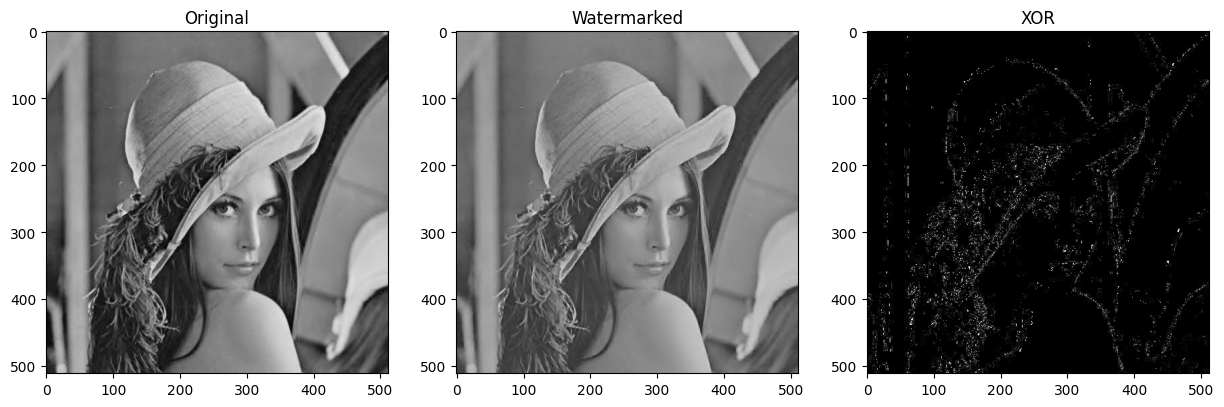

In [24]:
import pywt
import os
from scipy.fft import dct, idct
import numpy as np
import matplotlib.pyplot as plt
import cv2
from scipy.signal import convolve2d
from math import sqrt

def wpsnr(img1, img2):
  img1 = np.float32(img1)/255.0
  img2 = np.float32(img2)/255.0
  difference = img1-img2
  same = not np.any(difference)
  if same is True:
      return 9999999
  w = np.genfromtxt('csf.csv', delimiter=',')
  ew = convolve2d(difference, np.rot90(w,2), mode='valid')
  decibels = 20.0*np.log10(1.0/sqrt(np.mean(np.mean(ew**2))))
  return decibels

def create_perceptual_mask(subband):

    mask = np.ones(subband.shape)
    mask = compute_brightness_sensitivity(subband) * compute_edge_sensitivity(subband) * compute_texture_sensitivity(subband)
    
    return mask

def compute_brightness_sensitivity(subband):

    # Normalize brightness between 0 and 1
    min_brightness = np.min(subband)
    max_brightness = np.max(subband)
    brightness_sensitivity = (subband - min_brightness) / (max_brightness - min_brightness + 1e-6)
    
    # Invert to give higher sensitivity in dark areas (lower brightness = higher mask value)
    return 1 - brightness_sensitivity

def compute_edge_sensitivity(subband):

    # Compute image gradient (strong edges correspond to higher gradients)
    sobel_x = cv2.Sobel(subband, cv2.CV_64F, 1, 0, ksize=3)
    sobel_y = cv2.Sobel(subband, cv2.CV_64F, 0, 1, ksize=3)
    gradient_magnitude = np.sqrt(sobel_x**2 + sobel_y**2)
    
    # Normalize gradient magnitude between 0 and 1
    gradient_sensitivity = (gradient_magnitude - np.min(gradient_magnitude)) / (np.max(gradient_magnitude) - np.min(gradient_magnitude) + 1e-6)
    
    return gradient_sensitivity

def compute_texture_sensitivity(subband):
    
    # Compute local variance as a measure of texture
    mean = cv2.blur(subband, (3, 3))
    local_variance = cv2.blur((subband - mean) ** 2, (3, 3))
    
    # Normalize local variance between 0 and 1
    texture_sensitivity = (local_variance - np.min(local_variance)) / (np.max(local_variance) - np.min(local_variance) + 1e-6)
    
    return texture_sensitivity

def modularAlpha(layer, theta, alpha):
    arrayLayer = [1.0, 0.32, 0.16, 0.1]
    arrayTheta = [1, sqrt(2), 1]

    return alpha * arrayLayer[layer] * arrayTheta[theta]

def embedding(image, mark_size, alpha, v='multiplicative'):

    # Generate a watermark
    mark = np.random.uniform(0.0, 1.0, mark_size)
    mark = np.uint8(np.rint(mark))
    np.save('mark.npy', mark)

    coeffs2 = pywt.dwt2(image, 'haar')
    LL0, (LH0, HL0, HH0) = coeffs2

    coeffs3 = pywt.dwt2(LL0, 'haar')
    LL1, (LH1, HL1, HH1) = coeffs3

    coeffs4 = pywt.dwt2(LL1, 'haar')
    LL2, (LH2, HL2, HH2) = coeffs4

    coeffs5 = pywt.dwt2(LL2, 'haar')
    LL3, (LH3, HL3, HH3) = coeffs5

    # Create the mask for all the different subbands

    mask_LH0 = np.ones(LH0.shape)
    mask_HL0 = np.ones(HL0.shape)
    mask_HH0 = np.ones(HH0.shape)

    mask_LH1 = np.ones(LH1.shape)
    mask_HL1 = np.ones(HL1.shape)
    mask_HH1 = np.ones(HH1.shape)

    mask_LH2 = np.ones(LH2.shape)
    mask_HL2 = np.ones(HL2.shape)
    mask_HH2 = np.ones(HH2.shape)

    mask_LH0 += create_perceptual_mask(LH0)
    mask_HL0 += create_perceptual_mask(HL0)
    mask_HH0 += create_perceptual_mask(HH0)

    mask_LH1 += create_perceptual_mask(LH1)
    mask_HL1 += create_perceptual_mask(HL1)
    mask_HH1 += create_perceptual_mask(HH1)

    mask_LH2 += create_perceptual_mask(LH2)
    mask_HL2 += create_perceptual_mask(HL2)
    mask_HH2 += create_perceptual_mask(HH2)

    # Get the locations in LH0
    sign_LH0 = np.sign(LH0)
    abs_LH0 = abs(LH0)
    locations_LH0 = np.argsort(-abs_LH0,axis=None) # - sign is used to get descending order
    rows_LH0 = LH0.shape[0]
    locations_LH0 = [(val//rows_LH0, val%rows_LH0) for val in locations_LH0] # locations as (x,y) coordinates

    # Get the locations in HL0
    sign_HL0 = np.sign(HL0)
    abs_HL0 = abs(HL0)
    locations_HL0 = np.argsort(-abs_HL0,axis=None) # - sign is used to get descending order
    rows_HL0 = HL0.shape[0]
    locations_HL0 = [(val//rows_HL0, val%rows_HL0) for val in locations_HL0] # locations as (x,y) coordinates

    # Get the locations in HH0
    sign_HH0 = np.sign(HH0)
    abs_HH0 = abs(HH0)
    locations_HH0 = np.argsort(-abs_HH0,axis=None) # - sign is used to get descending order
    rows_HH0 = HH0.shape[0]
    locations_HH0 = [(val//rows_HH0, val%rows_HH0) for val in locations_HH0] # locations as (x,y) coordinates
    
    # Embed the watermark in LH0
    watermarked_LH0 = abs_LH0.copy()
    for idx, (loc,mark_val) in enumerate(zip(locations_LH0[1:], mark)):
        if v == 'additive':
            layer = 0
            theta = 0
            x = locations_LH0[idx][0]
            y = locations_LH0[idx][1]
            watermarked_LH0[loc] += (modularAlpha(layer, theta, alpha) * mark_val * mask_LH0[x][y])
        elif v == 'multiplicative':
            layer = 0
            theta = 0
            x = locations_LH0[idx][0]
            y = locations_LH0[idx][1]
            watermarked_LH0[loc] *= 1 + (modularAlpha(layer, theta, alpha) * mark_val * mask_LH0[x][y])
    
     # Embed the watermark in HL0
    watermarked_HL0 = abs_HL0.copy()
    for idx, (loc,mark_val) in enumerate(zip(locations_HL0[1:], mark)):
        if v == 'additive':
            layer = 0
            theta = 2
            x = locations_HL0[idx][0]
            y = locations_HL0[idx][1]
            watermarked_HL0[loc] += (modularAlpha(layer, theta, alpha) * mark_val * mask_HL0[x][y])
        elif v == 'multiplicative':
            layer = 0
            theta = 2
            x = locations_HL0[idx][0]
            y = locations_HL0[idx][1]
            watermarked_HL0[loc] *= 1 + (modularAlpha(layer, theta, alpha) * mark_val * mask_HL0[x][y])
    
     # Embed the watermark in HH0
    watermarked_HH0 = abs_HH0.copy()
    for idx, (loc,mark_val) in enumerate(zip(locations_HH0[1:], mark)):
        if v == 'additive':
            layer = 0
            theta = 1
            x = locations_HH0[idx][0]
            y = locations_HH0[idx][1]
            watermarked_HH0[loc] += (modularAlpha(layer, theta, alpha) * mark_val * mask_HH0[x][y])
        elif v == 'multiplicative':
            layer = 0
            theta = 1
            x = locations_HH0[idx][0]
            y = locations_HH0[idx][1]
            watermarked_HH0[loc] *= 1 + (modularAlpha(layer, theta, alpha) * mark_val * mask_HH0[x][y])

    # Get the locations in LH1
    sign_LH1 = np.sign(LH1)
    abs_LH1 = abs(LH1)
    locations_LH1 = np.argsort(-abs_LH1,axis=None) # - sign is used to get descending order
    rows_LH1 = LH1.shape[0]
    locations_LH1 = [(val//rows_LH1, val%rows_LH1) for val in locations_LH1] # locations as (x,y) coordinates

    # Get the locations in HL1
    sign_HL1 = np.sign(HL1)
    abs_HL1 = abs(HL1)
    locations_HL1 = np.argsort(-abs_HL1,axis=None) # - sign is used to get descending order
    rows_HL1 = HL1.shape[0]
    locations_HL1 = [(val//rows_HL1, val%rows_HL1) for val in locations_HL1] # locations as (x,y) coordinates

    # Get the locations in HH1
    sign_HH1 = np.sign(HH1)
    abs_HH1 = abs(HH1)
    locations_HH1 = np.argsort(-abs_HH1,axis=None) # - sign is used to get descending order
    rows_HH1 = HH1.shape[0]
    locations_HH1 = [(val//rows_HH1, val%rows_HH1) for val in locations_HH1] # locations as (x,y) coordinates
    
    # Embed the watermark in LH1
    watermarked_LH1 = abs_LH1.copy()
    for idx, (loc,mark_val) in enumerate(zip(locations_LH1[1:], mark)):
        if v == 'additive':
            layer = 1
            theta = 0
            x = locations_LH1[idx][0]
            y = locations_LH1[idx][1]
            watermarked_LH1[loc] += (modularAlpha(layer, theta, alpha) * mark_val * mask_LH1[x][y])
        elif v == 'multiplicative':
            layer = 1
            theta = 0
            x = locations_LH1[idx][0]
            y = locations_LH1[idx][1]
            watermarked_LH1[loc] *= 1 + (modularAlpha(layer, theta, alpha) * mark_val * mask_LH1[x][y])
    
     # Embed the watermark in HL1
    watermarked_HL1 = abs_HL1.copy()
    for idx, (loc,mark_val) in enumerate(zip(locations_HL1[1:], mark)):
        if v == 'additive':
            layer = 1
            theta = 2
            x = locations_HL1[idx][0]
            y = locations_HL1[idx][1]
            watermarked_HL1[loc] += (modularAlpha(layer, theta, alpha) * mark_val * mask_HL1[x][y])
        elif v == 'multiplicative':
            layer = 1
            theta = 2
            x = locations_HL1[idx][0]
            y = locations_HL1[idx][1]
            watermarked_HL1[loc] *= 1 + (modularAlpha(layer, theta, alpha) * mark_val * mask_HL1[x][y])
    
     # Embed the watermark in HH1
    watermarked_HH1 = abs_HH1.copy()
    for idx, (loc,mark_val) in enumerate(zip(locations_HH1[1:], mark)):
        if v == 'additive':
            layer = 1
            theta = 1
            x = locations_HH1[idx][0]
            y = locations_HH1[idx][1]
            watermarked_HH1[loc] += (modularAlpha(layer, theta, alpha) * mark_val * mask_HH1[x][y])
        elif v == 'multiplicative':
            layer = 1
            theta = 1
            x = locations_HH1[idx][0]
            y = locations_HH1[idx][1]
            watermarked_HH1[loc] *= 1 + (modularAlpha(layer, theta, alpha) * mark_val * mask_HH1[x][y])

# Get the locations in LH2
    sign_LH2 = np.sign(LH2)
    abs_LH2 = abs(LH2)
    locations_LH2 = np.argsort(-abs_LH2,axis=None) # - sign is used to get descending order
    rows_LH2 = LH2.shape[0]
    locations_LH2 = [(val//rows_LH2, val%rows_LH2) for val in locations_LH2] # locations as (x,y) coordinates

    # Get the locations in HL2
    sign_HL2 = np.sign(HL2)
    abs_HL2 = abs(HL2)
    locations_HL2 = np.argsort(-abs_HL2,axis=None) # - sign is used to get descending order
    rows_HL2 = HL2.shape[0]
    locations_HL2 = [(val//rows_HL2, val%rows_HL2) for val in locations_HL2] # locations as (x,y) coordinates

    # Get the locations in HH2
    sign_HH2 = np.sign(HH2)
    abs_HH2 = abs(HH2)
    locations_HH2 = np.argsort(-abs_HH2,axis=None) # - sign is used to get descending order
    rows_HH2 = HH2.shape[0]
    locations_HH2 = [(val//rows_HH2, val%rows_HH2) for val in locations_HH2] # locations as (x,y) coordinates

    # Embed the watermark in LH2
    watermarked_LH2 = abs_LH2.copy()
    for idx, (loc,mark_val) in enumerate(zip(locations_LH2[1:], mark)):
        if v == 'additive':
            layer = 2
            theta = 0
            x = locations_LH2[idx][0]
            y = locations_LH2[idx][1]
            watermarked_LH2[loc] += (modularAlpha(layer, theta, alpha) * mark_val * mask_LH2[x][y])
        elif v == 'multiplicative':
            layer = 2
            theta = 0
            x = locations_LH2[idx][0]
            y = locations_LH2[idx][1]
            watermarked_LH2[loc] *= 1 + (modularAlpha(layer, theta, alpha) * mark_val * mask_LH2[x][y])
    
     # Embed the watermark in HL2
    watermarked_HL2 = abs_HL2.copy()
    for idx, (loc,mark_val) in enumerate(zip(locations_HL2[1:], mark)):
        if v == 'additive':
            layer = 2
            theta = 2
            x = locations_HL2[idx][0]
            y = locations_HL2[idx][1]
            watermarked_HL2[loc] += (modularAlpha(layer, theta, alpha) * mark_val * mask_HL2[x][y])
        elif v == 'multiplicative':
            layer = 2
            theta = 2
            x = locations_HL2[idx][0]
            y = locations_HL2[idx][1]
            watermarked_HL2[loc] *= 1 + (modularAlpha(layer, theta, alpha) * mark_val * mask_HL2[x][y])
    
     # Embed the watermark in HH2
    watermarked_HH2 = abs_HH2.copy()
    for idx, (loc,mark_val) in enumerate(zip(locations_HH2[1:], mark)):
        if v == 'additive':
            layer = 2
            theta = 1
            x = locations_HH2[idx][0]
            y = locations_HH2[idx][1]
            watermarked_HH2[loc] += (modularAlpha(layer, theta, alpha) * mark_val * mask_HH2[x][y])
        elif v == 'multiplicative':
            layer = 2
            theta = 1
            x = locations_HH2[idx][0]
            y = locations_HH2[idx][1]
            watermarked_HH2[loc] *= 1 + (modularAlpha(layer, theta, alpha) * mark_val * mask_HH2[x][y])

    
    # Restore sign and o back to spatial domain

    watermarked_LL2 = pywt.idwt2((LL3, (LH3, HL3, HH3)), 'haar')

    watermarked_LH2 *= sign_LH2
    watermarked_HL2 *= sign_HL2
    watermarked_HH2 *= sign_HH2
    watermarked_LL1 = pywt.idwt2((watermarked_LL2, (watermarked_LH2, watermarked_HL2, watermarked_HH2)), 'haar')

    watermarked_LH1 *= sign_LH1
    watermarked_HL1 *= sign_HL1
    watermarked_HH1 *= sign_HH1
    watermarked_LL0 = pywt.idwt2((watermarked_LL1, (watermarked_LH1, watermarked_HL1, watermarked_HH1)), 'haar')

    watermarked_LH0 *= sign_LH0
    watermarked_HL0 *= sign_HL0
    watermarked_HH0 *= sign_HH0
    watermarked = pywt.idwt2((watermarked_LL0, (watermarked_LH0, watermarked_HL0, watermarked_HH0)), 'haar')

    return mark, watermarked

img_path='lena_grey.bmp'
image = cv2.imread(img_path, 0)
N = 1024
alpha = 1
v = 'multiplicative'

mark, watermarkedPicture = embedding(image, N, alpha, v='multiplicative')
wspnr_watermarked = wpsnr(image, watermarkedPicture)

cv2.imwrite('./out/watermarkedPicture.bmp', watermarkedPicture)

# Load the images
image1 = cv2.imread('lena_grey.bmp')
image2 = cv2.imread('./out/watermarkedPicture.bmp')

# Convert images to the same data type (uint8)
image1 = image1.astype(np.uint8)
image2 = image2.astype(np.uint8)

# Perform the XOR operation
xor_image = cv2.bitwise_xor(image1, image2)

# Save or display the result
cv2.imwrite('./out/xor_output_image.bmp', xor_image)

plt.figure(figsize=(15, 9))
plt.subplot(131)
plt.title('Original')
plt.imshow(image, cmap='gray')
plt.subplot(132)
plt.title('Watermarked')
plt.imshow(watermarkedPicture, cmap='gray')
plt.subplot(133)
plt.title('XOR')
plt.imshow(xor_image, cmap='gray')

print('WPSNR non-ATTACKED IMAGE = ', wspnr_watermarked)



WPSNR non-ATTACKED IMAGE =  47.38645045396446
WPSNR ATTACKED IMAGE =  45.1101419678022
Threshold:  0.7045969013191931


Mark has been found in the non-attacked image. SIM = 1.000000
Mark has been found in the attacked image. SIM = 0.863225
--------------------------




/tmp/ipykernel_17356/3205697866.py:3: RuntimeWarning: invalid value encountered in scalar divide
  s = np.sum(np.multiply(X, X_star)) / (np.sqrt(np.sum(np.multiply(X, X))) * np.sqrt(np.sum(np.multiply(X_star, X_star))))


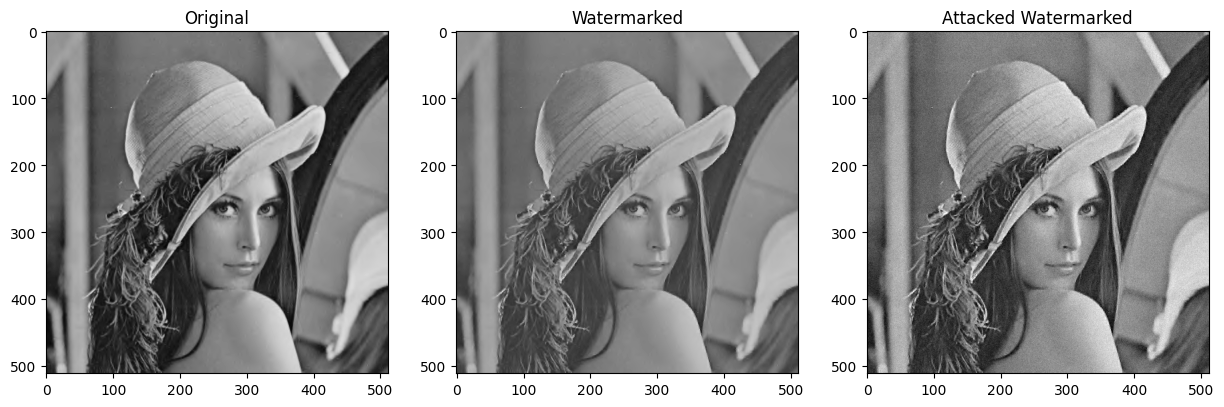

In [25]:
def similarity(X,X_star):
    #Computes the similarity measure between the original and the new watermarks.
    s = np.sum(np.multiply(X, X_star)) / (np.sqrt(np.sum(np.multiply(X, X))) * np.sqrt(np.sum(np.multiply(X_star, X_star))))
    return s


def compute_thr(sim, mark_size, w, N):
    SIM = np.zeros(N)
    for i in range(N):
        r = np.random.uniform(0.0, 1.0, mark_size)
        SIM[i] = (similarity(w, r))
    SIMs = SIM.copy()
    SIM.sort()
    t = SIM[-1]
    T = t + (0.1*t)
    print('Threshold: ', T)
    return T, SIMs

#select your attack 

def awgn(img, std, seed):
  mean = 0.0   # some constant
  np.random.seed(seed)
  attacked = img + np.random.normal(mean, std, img.shape)
  attacked = np.clip(attacked, 0, 255)
  return np.uint8(attacked)

def detection(image, watermarked, alpha, mark_size, v='multiplicative'):
    #ori_dct = dct(dct(image,axis=0, norm='ortho'),axis=1, norm='ortho')
    coeffs2 = pywt.dwt2(image, 'haar')
    LL0_or, (LH0_or, HL0_or, HH0_or) = coeffs2
    coeffs3 = pywt.dwt2(LL0_or, 'haar')
    LL1_or, (LH1_or, HL1_or, HH1_or) = coeffs3
    coeffs4 = pywt.dwt2(LL1_or, 'haar')
    LL2_or, (LH2_or, HL2_or, HH2_or) = coeffs4
    coeffs5 = pywt.dwt2(LL2_or, 'haar')
    LL3_or, (LH3_or, HL3_or, HH3_or) = coeffs5

    #wat_dct = dct(dct(watermarked,axis=0, norm='ortho'),axis=1, norm='ortho')
    coeffs6 = pywt.dwt2(watermarked, 'haar')
    LL0_w, (LH0_w, HL0_w, HH0_w) = coeffs6
    coeffs7 = pywt.dwt2(LL0_w, 'haar')
    LL1_w, (LH1_w, HL1_w, HH1_w) = coeffs7
    coeffs8 = pywt.dwt2(LL1_w, 'haar')
    LL2_w, (LH2_w, HL2_w, HH2_w) = coeffs8
    coeffs9 = pywt.dwt2(LL2_w, 'haar')
    LL3_w, (LH3_w, HL3_w, HH3_w) = coeffs9

    # Create the mask for all the different subbands

    mask_LH0 = np.ones(LH0_or.shape)
    mask_HL0 = np.ones(HL0_or.shape)
    mask_HH0 = np.ones(HH0_or.shape)

    mask_LH1 = np.ones(LH1_or.shape)
    mask_HL1 = np.ones(HL1_or.shape)
    mask_HH1 = np.ones(HH1_or.shape)

    mask_LH2 = np.ones(LH2_or.shape)
    mask_HL2 = np.ones(HL2_or.shape)
    mask_HH2 = np.ones(HH2_or.shape)

    mask_LH0 += create_perceptual_mask(LH0_or)
    mask_HL0 += create_perceptual_mask(HL0_or)
    mask_HH0 += create_perceptual_mask(HH0_or)

    mask_LH1 += create_perceptual_mask(LH1_or)
    mask_HL1 += create_perceptual_mask(HL1_or)
    mask_HH1 += create_perceptual_mask(HH1_or)

    mask_LH2 += create_perceptual_mask(LH2_or)
    mask_HL2 += create_perceptual_mask(HL2_or)
    mask_HH2 += create_perceptual_mask(HH2_or)


    # Get the locations in LH2
    sign_LH2 = np.sign(LH2_or)
    abs_LH2 = abs(LH2_or)
    locations_LH2 = np.argsort(-abs_LH2,axis=None) # - sign is used to get descending order
    rows_LH2 = LH2_or.shape[0]
    locations_LH2 = [(val//rows_LH2, val%rows_LH2) for val in locations_LH2] # locations as (x,y) coordinates


    # Get the locations in HL2
    sign_HL2 = np.sign(HL2_or)
    abs_HL2 = abs(HL2_or)
    locations_HL2 = np.argsort(-abs_HL2,axis=None) # - sign is used to get descending order
    rows_HL2 = HL2_or.shape[0]
    locations_HL2 = [(val//rows_HL2, val%rows_HL2) for val in locations_HL2] # locations as (x,y) coordinates

    # Get the locations in HH2
    sign_HH2 = np.sign(HH2_or)
    abs_HH2 = abs(HH2_or)
    locations_HH2 = np.argsort(-abs_HH2,axis=None) # - sign is used to get descending order
    rows_HH2 = HH2_or.shape[0]
    locations_HH2 = [(val//rows_HH2, val%rows_HH2) for val in locations_HH2] # locations as (x,y) coordinates

    # Generate a watermark
    w_ex1_2 = np.zeros(mark_size, dtype=np.float64)
    w_ex2_2 = np.zeros(mark_size, dtype=np.float64)
    w_ex3_2 = np.zeros(mark_size, dtype=np.float64)

    # Embed the watermark
    for idx, loc in enumerate(locations_LH2[1:mark_size+1]):
        if v=='additive':
            x = locations_LH2[idx][0]
            y = locations_LH2[idx][1]
            w_ex1_2[idx] =  (LH2_w[loc] - LH2_or[loc]) / modularAlpha(2, 0, alpha) * mask_LH2[x][y]
        elif v=='multiplicative':
            x = locations_LH2[idx][0]
            y = locations_LH2[idx][1]
            w_ex1_2[idx] =  (LH2_w[loc] - LH2_or[loc]) / (modularAlpha(2, 0, alpha) * mask_LH2[x][y] * LH2_or[loc])

    # Embed the watermark
    for idx, loc in enumerate(locations_HL2[1:mark_size+1]):
        if v=='additive':
            x = locations_HL2[idx][0]
            y = locations_HL2[idx][1]
            w_ex1_2[idx] =  (HL2_w[loc] - HL2_or[loc]) / modularAlpha(2, 2, alpha) * mask_HL2[x][y]
        elif v=='multiplicative':
            x = locations_HL2[idx][0]
            y = locations_HL2[idx][1]
            w_ex1_2[idx] =  (HL2_w[loc] - HL2_or[loc]) / (modularAlpha(2, 2, alpha) * mask_HL2[x][y] * HL2_or[loc])
    
    # Embed the watermark
    for idx, loc in enumerate(locations_HH2[1:mark_size+1]):
        if v=='additive':
            x = locations_HH2[idx][0]
            y = locations_HH2[idx][1]
            w_ex1_2[idx] =  (HH2_w[loc] - HH2_or[loc]) / modularAlpha(2, 1, alpha) * mask_HH2[x][y]
        elif v=='multiplicative':
            x = locations_HH2[idx][0]
            y = locations_HH2[idx][1]
            w_ex1_2[idx] =  (HH2_w[loc] - HH2_or[loc]) / (modularAlpha(2, 1, alpha) * mask_HH2[x][y] * HH2_or[loc])

     # Get the locations in LH1
    sign_LH1 = np.sign(LH1_or)
    abs_LH1 = abs(LH1_or)
    locations_LH1 = np.argsort(-abs_LH1,axis=None) # - sign is used to get descending order
    rows_LH1 = LH1_or.shape[0]
    locations_LH1 = [(val//rows_LH1, val%rows_LH1) for val in locations_LH1] # locations as (x,y) coordinates


    # Get the locations in HL1
    sign_HL1 = np.sign(HL1_or)
    abs_HL1 = abs(HL1_or)
    locations_HL1 = np.argsort(-abs_HL1,axis=None) # - sign is used to get descending order
    rows_HL1 = HL1_or.shape[0]
    locations_HL1 = [(val//rows_HL1, val%rows_HL1) for val in locations_HL1] # locations as (x,y) coordinates

    # Get the locations in HH
    sign_HH1 = np.sign(HH1_or)
    abs_HH1 = abs(HH1_or)
    locations_HH1 = np.argsort(-abs_HH1,axis=None) # - sign is used to get descending order
    rows_HH1 = HH1_or.shape[0]
    locations_HH1 = [(val//rows_HH1, val%rows_HH1) for val in locations_HH1] # locations as (x,y) coordinates

    # Generate a watermark
    w_ex1_1 = np.zeros(mark_size, dtype=np.float64)
    w_ex2_1 = np.zeros(mark_size, dtype=np.float64)
    w_ex3_1 = np.zeros(mark_size, dtype=np.float64)

    # Embed the watermark
    for idx, loc in enumerate(locations_LH1[1:mark_size+1]):
        if v=='additive':
            x = locations_LH1[idx][0]
            y = locations_LH1[idx][1]
            w_ex1_1[idx] =  (LH1_w[loc] - LH1_or[loc]) / modularAlpha(1, 0, alpha) * mask_LH1[x][y]
        elif v=='multiplicative':
            x = locations_LH1[idx][0]
            y = locations_LH1[idx][1]
            w_ex1_1[idx] =  (LH1_w[loc] - LH1_or[loc]) / (modularAlpha(1, 0, alpha) * mask_LH1[x][y] * LH1_or[loc])

    # Embed the watermark
    for idx, loc in enumerate(locations_HL1[1:mark_size+1]):
        if v=='additive':
            x = locations_HL1[idx][0]
            y = locations_HL1[idx][1]
            w_ex1_1[idx] =  (HL1_w[loc] - HL1_or[loc]) / modularAlpha(1, 2, alpha) * mask_HL1[x][y]
        elif v=='multiplicative':
            x = locations_HL1[idx][0]
            y = locations_HL1[idx][1]
            w_ex1_1[idx] =  (HL1_w[loc] - HL1_or[loc]) / (modularAlpha(1, 2, alpha) * mask_HL1[x][y] * HL1_or[loc])
    
    # Embed the watermark
    for idx, loc in enumerate(locations_HH1[1:mark_size+1]):
        if v=='additive':
            x = locations_HH1[idx][0]
            y = locations_HH1[idx][1]
            w_ex1_1[idx] =  (HH1_w[loc] - HH1_or[loc]) / modularAlpha(1, 1, alpha) * mask_HH1[x][y]
        elif v=='multiplicative':
            x = locations_HH1[idx][0]
            y = locations_HH1[idx][1]
            w_ex1_1[idx] =  (HH1_w[loc] - HH1_or[loc]) / (modularAlpha(1, 1, alpha) * mask_HH1[x][y] * HH1_or[loc])
    
     # Get the locations in LH0
    sign_LH0 = np.sign(LH0_or)
    abs_LH0 = abs(LH0_or)
    locations_LH0 = np.argsort(-abs_LH0,axis=None) # - sign is used to get descending order
    rows_LH0 = LH0_or.shape[0]
    locations_LH0 = [(val//rows_LH0, val%rows_LH0) for val in locations_LH0] # locations as (x,y) coordinates


    # Get the locations in HL0
    sign_HL0 = np.sign(HL0_or)
    abs_HL0 = abs(HL0_or)
    locations_HL0 = np.argsort(-abs_HL0,axis=None) # - sign is used to get descending order
    rows_HL0 = HL0_or.shape[0]
    locations_HL0 = [(val//rows_HL0, val%rows_HL0) for val in locations_HL0] # locations as (x,y) coordinates

    # Get the locations in HH
    sign_HH0 = np.sign(HH0_or)
    abs_HH0 = abs(HH0_or)
    locations_HH0 = np.argsort(-abs_HH0,axis=None) # - sign is used to get descending order
    rows_HH0 = HH0_or.shape[0]
    locations_HH0 = [(val//rows_HH0, val%rows_HH0) for val in locations_HH0] # locations as (x,y) coordinates

    # Generate a watermark
    w_ex1_0 = np.zeros(mark_size, dtype=np.float64)
    w_ex2_0 = np.zeros(mark_size, dtype=np.float64)
    w_ex3_0 = np.zeros(mark_size, dtype=np.float64)

    # Embed the watermark
    for idx, loc in enumerate(locations_LH0[1:mark_size+1]):
        if v=='additive':
            x = locations_LH0[idx][0]
            y = locations_LH0[idx][1]
            w_ex1_0[idx] =  (LH0_w[loc] - LH0_or[loc]) / modularAlpha(0, 0, alpha) * mask_LH0[x][y]
        elif v=='multiplicative':
            x = locations_LH0[idx][0]
            y = locations_LH0[idx][1]
            w_ex1_0[idx] =  (LH0_w[loc] - LH0_or[loc]) / (modularAlpha(0, 0, alpha) * mask_LH0[x][y] * LH0_or[loc])

    # Embed the watermark
    for idx, loc in enumerate(locations_HL0[1:mark_size+1]):
        if v=='additive':
            x = locations_HL0[idx][0]
            y = locations_HL0[idx][1]
            w_ex1_0[idx] =  (HL0_w[loc] - HL0_or[loc]) / modularAlpha(0, 2, alpha) * mask_HL0[x][y]
        elif v=='multiplicative':
            x = locations_HL0[idx][0]
            y = locations_HL0[idx][1]
            w_ex1_0[idx] =  (HL0_w[loc] - HL0_or[loc]) / (modularAlpha(0, 2, alpha) * mask_HL0[x][y] * HL0_or[loc])
    
    # Embed the watermark
    for idx, loc in enumerate(locations_HH0[1:mark_size+1]):
        if v=='additive':
            x = locations_HH0[idx][0]
            y = locations_HH0[idx][1]
            w_ex1_0[idx] =  (HH0_w[loc] - HH0_or[loc]) / modularAlpha(0, 1, alpha) * mask_HH0[x][y]
        elif v=='multiplicative':
            x = locations_HH0[idx][0]
            y = locations_HH0[idx][1]
            w_ex1_0[idx] =  (HH0_w[loc] - HH0_or[loc]) / (modularAlpha(0, 1, alpha) * mask_HH0[x][y] * HH0_or[loc])

    return [w_ex1_0, w_ex2_0, w_ex3_0, w_ex1_1, w_ex2_1, w_ex3_1, w_ex1_2, w_ex2_2, w_ex3_2]

#######  your attack  ########

attacked = awgn(watermarkedPicture, 8, 123)


plt.figure(figsize=(15, 9))
plt.subplot(131)
plt.title('Original')
plt.imshow(image, cmap='gray')
plt.subplot(132)
plt.title('Watermarked')
plt.imshow(watermarkedPicture, cmap='gray')
plt.subplot(133)
plt.title('Attacked Watermarked')
plt.imshow(attacked,cmap='gray')

#detection
candidate_wm = detection(image, watermarkedPicture, alpha, N, v)
attacked_wm = detection(image, attacked, alpha, N, v)

#wpsnr
wspnr_watermarked = wpsnr(image, watermarkedPicture)
wpsner_attacked = wpsnr(watermarkedPicture, attacked)
print('\n')
print('WPSNR non-ATTACKED IMAGE = ', wspnr_watermarked)
print('WPSNR ATTACKED IMAGE = ', wpsner_attacked)
#similarity

sims_attacked = []
sims_not_attacked = []
for i,j in zip(candidate_wm, attacked_wm):
    sims_attacked.append(similarity(i, j))
    sims_not_attacked.append(similarity(i, mark))


sim_Attacked = max(sims_attacked)
sim_NOTattacked = max(sims_not_attacked)
Tau, _ = compute_thr(sim_NOTattacked, N, mark, 1000)
#watermark retrieved?
print('\n')
if sim_NOTattacked > Tau:
    print('Mark has been found in the non-attacked image. SIM = %f' % sim_NOTattacked)
else:
    print('Mark has been lost in the non-attacked image. SIM = %f' % sim_NOTattacked)
if sim_Attacked > Tau:
    print('Mark has been found in the attacked image. SIM = %f' % sim_Attacked)
else:
    print('Mark has been lost in the attacked image. SIM = %f' % sim_Attacked)
print('--------------------------')
print('\n')

# ROC

To find a better threshold estimation, **do not use just one single image**. Adapt the code of the ROC using the Spread Spectrum to compute the scores on different images (i.e. Lena, Baboon, etc.)

## Get new images

Download new images for your experiments from this [link](https://drive.google.com/file/d/1-n9bmQFDBShRN4Tr_WpmCf1jFHOS5MTO/view?usp=drive_link)

In [12]:
##YOUR CODE